In [1]:
%run 00_analysis_config.ipynb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

from iminuit import cost

## Basic numbers

In [4]:
DATA_DIR    = "/project/rrg-mdiamond/tomren/mudata/background/"

In [5]:
# Eta range
Eta_min = np.arcsinh(70/(85.47+6)) # Largest angle
Eta_max = np.arcsinh((70+99)/85.47) # Smallest angle
print("Eta min,max:",Eta_min,Eta_max)
print("Set simulation Eta min,max to:",0.65,1.5)

MODULE_Z_RANGE_CMS_cm = [70_00, 70_00+90_00]
MODULE_Y_RANGE_CMS_cm = [85_47, 85_47+11_00]

Eta min,max: 0.7053249760455805 1.433438284682681
Set simulation Eta min,max to: 0.65 1.5


---

In [7]:
filename = f"{DATA_DIR}/test/muon_cms__Pt_35_GeV//20231107/183808//stat_v1.root"

tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_track_id', 'Digi_layer_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_cov_t_x', 'Vertex_k_m_cov_t_y', 'Vertex_k_m_cov_t_z', 'Vertex_k_m_cov_x_y', 'Vertex_k_m_cov_x_z', 'Vertex_k_m_cov_y_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'Vertex_k_m_chi2', 'Vertex_k_m_c

In [8]:
# -------------------------------------
# LS fit
# ------------------------------------
class chi2_vertex:
    def __init__(self, tracks, track_covs):
        self.tracks=tracks
        self.track_covs=track_covs
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0'])
        self.errordef=1 # use least square
    def __call__(self, x0, y0, z0, t0):
        error=0
        for itrack in range(len(self.tracks)):
            error+= chi2_distance_to(self.tracks[itrack], self.track_covs[itrack], [x0, y0, z0], t0, point_t_err = 0)
        return error        

    
def fit_vertex(track_pars, track_covs, seedinedx=[0,1], ncall=2000):
    x0_init,y0_init, z0_init,t0_init = find_midpont_closestapproach(track_pars[seedinedx[0]], track_pars[seedinedx[1]])

    m = Minuit(chi2_vertex(track_pars, track_covs),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init)
    limit_ext=2_00 # Extend the limit to beyond the decay volume
    m.limits["x0"]=(detector.Detector.BoxLimits[0][0]-limit_ext, detector.Detector.BoxLimits[0][1]+limit_ext)
    m.limits["y0"]=(detector.Detector.BoxLimits[1][0]-limit_ext, detector.Detector.BoxLimits[1][1]+limit_ext)
    m.limits["z0"]=(detector.Detector.BoxLimits[2][0]-limit_ext, detector.Detector.BoxLimits[2][1]+limit_ext)
    m.limits["t0"]=(0,1000)
    m.errors["x0"]=1
    m.errors["y0"]=1
    m.errors["z0"]=1
    m.errors["t0"]=1

    m.migrad(ncall=ncall)  # run optimiser
    # m.hesse()   # run covariance estimator
    
    return m


            

In [9]:
def IP_track_cov(hit, hit_unc):
    """
    Construct the covariance of an "IP track" connecting from IP to a given hit
    
    Two points:
    # IP: [0, 0, 0, t-dt], Hit: [x, y, z, t] 
    Track:
    # Track: [x0, y0, z0, vx, vy, vx, t0] = [x, y, z, x/dt, y/dt, z/dt, t], in which dt = dr/c = sqrt(x^2+y^2+z^2)/c    
    
    """
    x,y,z,t = hit
    c = 29.979
    dt= np.linalg.norm(hit[:3])/c
    dt3c2 = dt**3 * c**2
    
    jac = np.array([[1,    0,     0,    1/dt - x**2/dt3c2,         - x*y/dt3c2,         - x*z/dt3c2,  0],
                   [0,    1,     0,         -  x*y/dt3c2,   1/dt - y**2/dt3c2,         - z*y/dt3c2,  0],
                   [0,    0,     1,         -  x*z/dt3c2,         - z*y/dt3c2,   1/dt - z**2/dt3c2,  0],
                   [0,    0,     0,                    0,                   0,                   0,  1]])

    track_cov = jac.T @ np.diag(hit_unc**2) @ jac
    return track_cov

In [13]:

Track_to_fwhits_chi2_all = []
Track_to_fwhits_dist_all = []
Track_to_IPtrack_chi2_all=[]
Track_to_IPtrack_dist_all=[]
Track_to_IPtrack_dist2_all=[]
Track_deflection_all = []

n_event_without_fw = 0

for entry in tqdm(range(nevents)):
# for entry in tqdm(range(2000)):
    Tree.GetEntry(entry)


    # Tracks
    track_digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
    n_tracks_recon = len(track_digi_hit_inds)
    tracks_chi2_to_fwhits=[]
    tracks_dist_to_fwhits=[]
    tracks_chi2_to_IPtrack=[]
    tracks_dist_to_IPtrack=[]
    tracks_dist2_to_IPtrack=[]
    tracks_deflection=[]
    momentum_truth = [Tree.GenParticle_py[0], -Tree.GenParticle_pz[0], Tree.GenParticle_px[0]]
    momentum_truth_unit = momentum_truth/np.linalg.norm(momentum_truth)

    if n_tracks_recon>0:

        # Hits
        hits_x = np.array(util.c2list(Tree.Digi_x))
        hits_y = np.array(util.c2list(Tree.Digi_y))
        hits_z = np.array(util.c2list(Tree.Digi_z))
        hits_t = np.array(util.c2list(Tree.Digi_time))
        hits_layer = np.array(util.c2list(Tree.Digi_layer_id))
        mask_non_fw = (hits_z>=MODULE_Z_RANGE_CMS_cm[0]) & (hits_y>=MODULE_Y_RANGE_CMS_cm[0])
        hits_xyz_non_fw = np.array([hits_x[mask_non_fw], hits_y[mask_non_fw], hits_z[mask_non_fw], hits_t[mask_non_fw]]).T
        hits_xyz_fw = np.array([hits_x[~mask_non_fw], hits_y[~mask_non_fw], hits_z[~mask_non_fw], hits_t[~mask_non_fw]]).T
        hits_id_fw = hits_layer[~mask_non_fw]
        n_hits_fw = len(hits_xyz_fw)
        
        # Loop track, and for each track loop F/W hits
        if n_hits_fw>0:
            for itrack in range(n_tracks_recon):
                track_param = get_track_param(Tree, itrack)
                track_cov = get_track_cov(Tree, itrack)
                momentum_measured = track_param[3:6]
                momentum_measured_unit = momentum_measured/np.linalg.norm(momentum_measured)

                chi2_to_fwhits = []
                dist_to_fwhits = []
                chi2_to_IPtrack= []
                dist_to_IPtrack= []                
                dist2_to_IPtrack= []                

                for ihit, hit in enumerate(hits_xyz_fw):
                    # Hit uncertainty:
                    hit_uncertainty = get_hit_uncertainty(1, hits_id_fw[ihit])
                    
                    # Method 1: Calculate chi2 between F/W hits and track
                    dt = hit[-1]-track_param[-1]
                    track_new_loc = track_point_propagation(track_param,dt)
                    dr = track_new_loc[:3] - hit[:3]
                    # Total covariance is the track cov + hit cov
                    track_new_pcov_inv = np.linalg.inv(track_cov_propagation(track_param, track_cov, dt, dt_err_add=1)+ np.diag(hit_uncertainty**2))
                    chi2 = dr.T@track_new_pcov_inv@dr
                    
                    # chi2 = chi2_distance_to(track_param, track_cov, hit[:3], hit[3], point_t_err = 1)
                    chi2_to_fwhits.append(chi2)
                    dist_to_fwhits.append(np.linalg.norm(dr))
                    
                    # Calculate chi2 between track and IP tracklet
                    # IP tracklet parameter
                    # Minimize chi2
                    # Log the distance and chi2 
                    dr_IP = np.linalg.norm(hit[:3])
                    dt_IP = dr_IP/29.94
                    v0_IP = hit[:3]/dt_IP
                    track2_par = [hit[0], hit[1], hit[2], v0_IP[0], v0_IP[1], v0_IP[2], hit[3]]
                    track2_cov = IP_track_cov(hit, np.append(hit_uncertainty,1))
                    # print(track2_cov)
                    fit1 = fit_vertex([track_param, track2_par], [track_cov, track2_cov], seedinedx=[0,1])
                    chi2_to_IPtrack.append(fit1.fval)
                    
                    # Calculate distance
                    vertex_par=np.array(list(fit1.values))
                    vertex_par_detcoor = util.coord_cms2det(vertex_par[:3])
                    hit_detcoor = util.coord_cms2det(hit[:3])
                    track1_location_at_vertex = np.array(track_point_propagation(track_param,vertex_par[-1]-track_param[-1]))
                    track2_location_at_vertex = np.array(track_point_propagation(track2_par, vertex_par[-1]-track2_par[-1]))
                    dr_fit = np.linalg.norm(track1_location_at_vertex[:3] - track2_location_at_vertex[:3])
                    dist_to_IPtrack.append(dr_fit)
                    
                    dist2_to_IPtrack.append(find_distance_closestapproach(track_param, track2_par))
                    

                ind_min = np.argmin(chi2_to_fwhits)
                tracks_chi2_to_fwhits.append(chi2_to_fwhits[ind_min])
                tracks_dist_to_fwhits.append(dist_to_fwhits[ind_min])
                tracks_chi2_to_IPtrack.append(chi2_to_IPtrack[ind_min])
                tracks_dist_to_IPtrack.append(dist_to_IPtrack[ind_min])
                tracks_dist2_to_IPtrack.append(dist2_to_IPtrack[ind_min])
                
                tracks_deflection.append(np.arccos(np.dot(momentum_truth_unit, momentum_measured_unit)))
                
        else:
            n_event_without_fw+=1
            print("Entry", entry,"does not have F/W hit")

    # Select the one with minimum chi2
    track_chi2_to_fwhits=np.min(tracks_chi2_to_fwhits) if len(tracks_chi2_to_fwhits)>0 else -999
    track_dist_to_fwhits=tracks_dist_to_fwhits[np.argmin(tracks_chi2_to_fwhits)] if len(tracks_chi2_to_fwhits)>0 else -999
    track_deflection   =tracks_deflection[np.argmin(tracks_chi2_to_fwhits)] if len(tracks_chi2_to_fwhits)>0 else -999
    
    track_chi2_to_IPtrack=np.min(tracks_chi2_to_IPtrack) if len(tracks_chi2_to_fwhits)>0 else -999
    track_dist_to_IPtrack=tracks_dist_to_IPtrack[np.argmin(tracks_chi2_to_IPtrack)] if len(tracks_chi2_to_fwhits)>0 else -999
    track_dist2_to_IPtrack=np.min(tracks_dist2_to_IPtrack) if len(tracks_chi2_to_fwhits)>0 else -999
    
    # Append to the output
    Track_to_fwhits_chi2_all.append(track_chi2_to_fwhits)
    Track_to_fwhits_dist_all.append(track_dist_to_fwhits)
    Track_to_IPtrack_chi2_all.append(track_chi2_to_IPtrack)
    Track_to_IPtrack_dist_all.append(track_dist_to_IPtrack)
    Track_to_IPtrack_dist2_all.append(track_dist2_to_IPtrack)
    Track_deflection_all.append(track_deflection)

Track_to_fwhits_chi2_all=np.array(Track_to_fwhits_chi2_all)
Track_to_fwhits_dist_all=np.array(Track_to_fwhits_dist_all)
Track_to_IPtrack_chi2_all=np.array(Track_to_IPtrack_chi2_all)
Track_to_IPtrack_dist_all=np.array(Track_to_IPtrack_dist_all)
Track_to_IPtrack_dist2_all=np.array(Track_to_IPtrack_dist2_all)
Track_deflection_all=np.array(Track_deflection_all)

print(n_event_without_fw, "events without F/W hits")

 78%|███████▊  | 11155/14283 [29:40<06:38,  7.85it/s] 

Entry 11154 does not have F/W hit


100%|██████████| 14283/14283 [37:36<00:00,  6.33it/s]

1 events without F/W hits


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '$\\chi^2$, track to F/W hits')

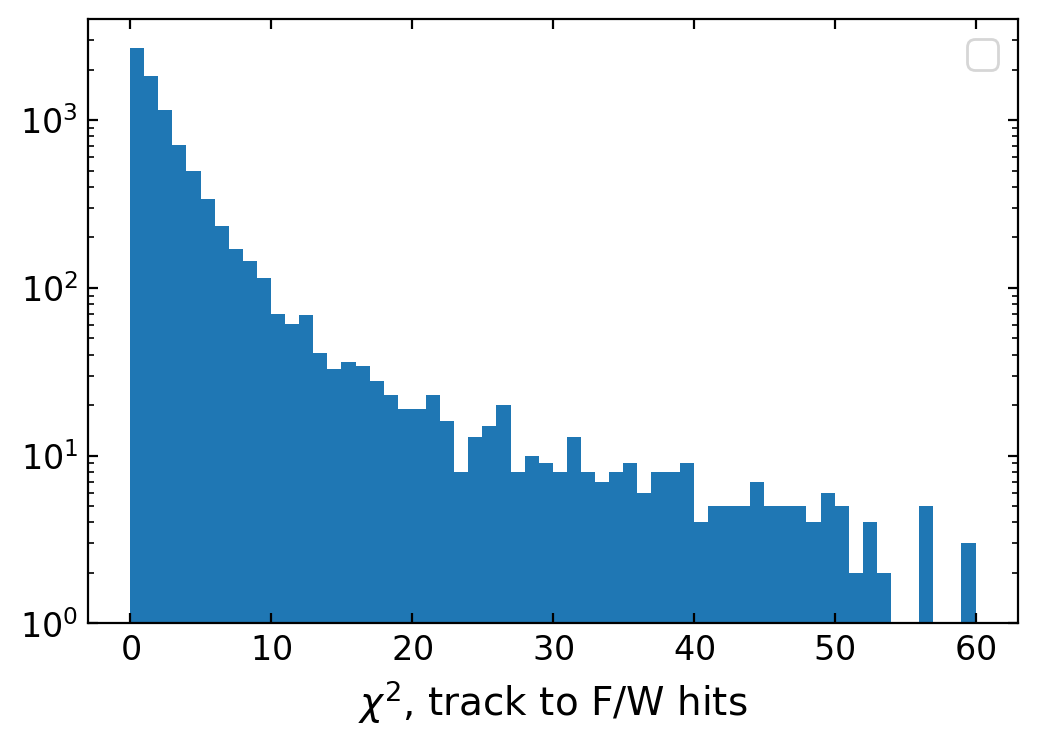

In [65]:
n1,ibins,p = hist(Track_to_fwhits_chi2_all[Track_to_fwhits_chi2_all>0],range=(0,60),bins=60);


# Fit for chi2 distribution
x = util.Utils.center(ibins)[:20]
y = n1 [:20]
yerr = np.sqrt(y)
yerr[yerr==0]=1
ndof_start=3
# our line model
def line(x, ndof, A):
    return scipy.stats.chi2.pdf(x, ndof)*A
# Cost function
least_squares = iminuit.cost.LeastSquares(x, y, yerr, line)
# Minimize
m = iminuit.Minuit(least_squares, ndof = ndof_start, A=max(y))  # starting values for α and β
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# Plot
# plot(x, line(x, *m.values),label=f"fit, ndof = {m.values[0]:.1f}", color="C1", linestyle="--")

yscale("log")
ylim(bottom=1)
legend()
xlabel(r"$\chi^2$, track to F/W hits")

Text(0.5, 0, 'Distance [cm], track to F/W hits')

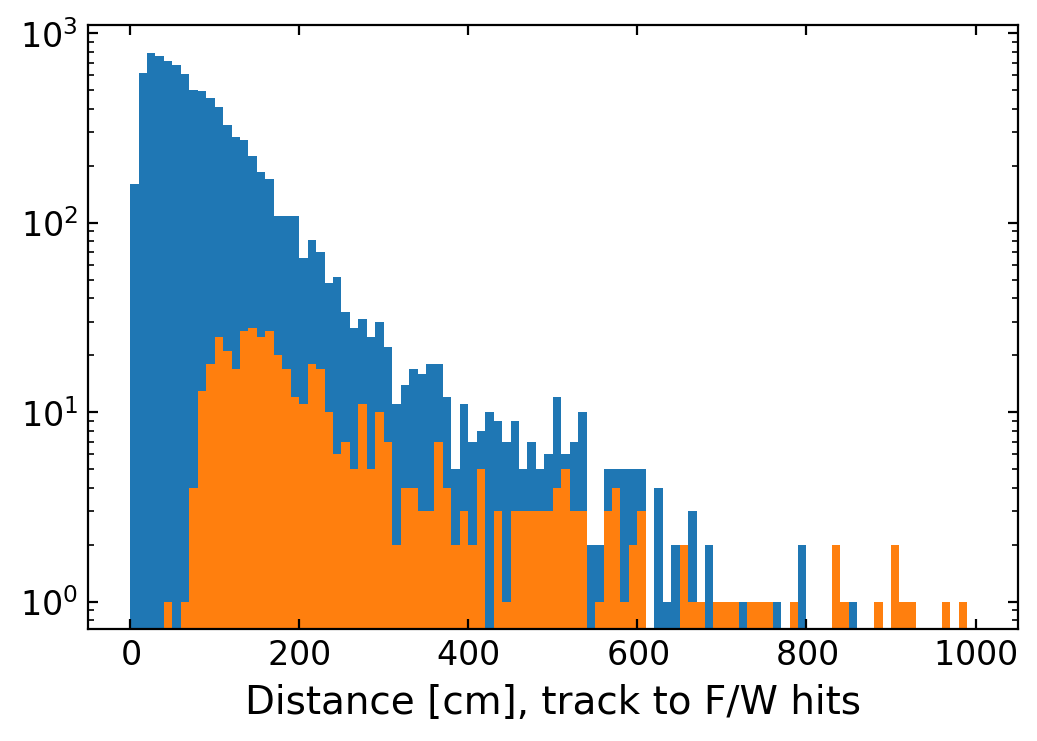

In [45]:
hist(Track_to_fwhits_dist_all[Track_to_fwhits_chi2_all>0], range=(0,1000));
hist(Track_to_fwhits_dist_all[Track_to_fwhits_chi2_all>20], range=(0,1000));
yscale("log")
xlabel("Distance [cm], track to F/W hits")

Text(0.5, 0, '$\\chi^2$, track to IP-tracklet')

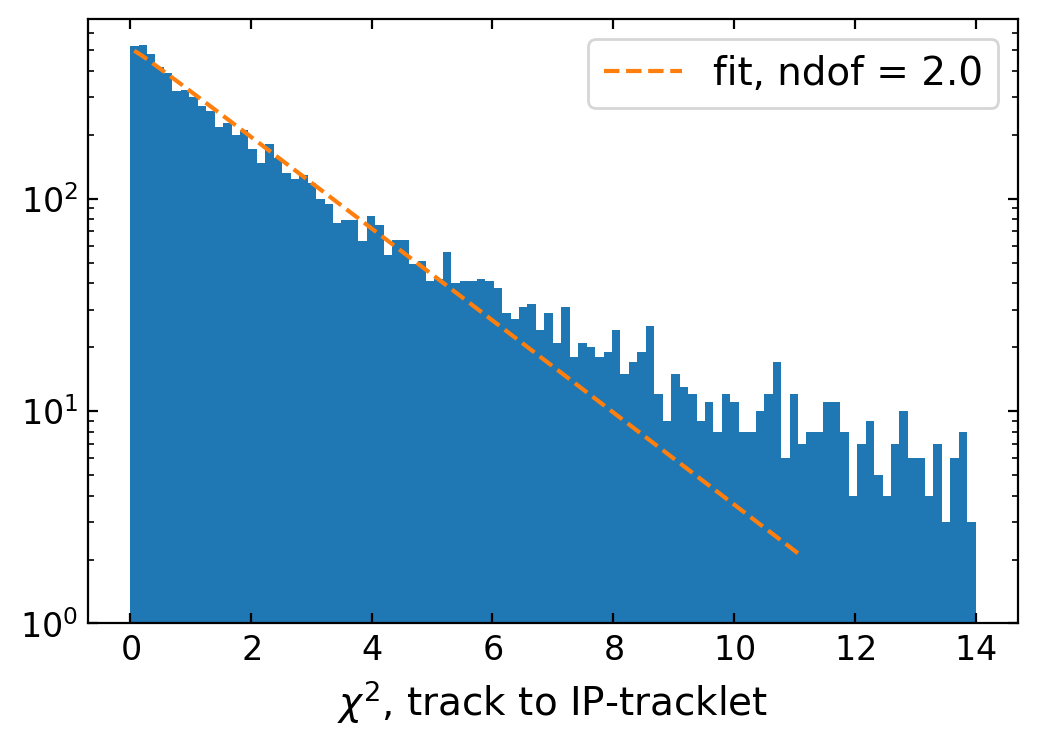

In [17]:
n1,ibins,p = hist(Track_to_IPtrack_chi2_all[Track_to_fwhits_chi2_all>0],range=(0,14),bins=100);
# n2,ibins,p = hist(Track_to_IPtrack_chi2_all[Track_to_fwhits_chi2_all>20],range=(0,100),bins=100);


# Fit for chi2 distribution
x = util.Utils.center(ibins)[:80]
y = n1 [:80]
yerr = np.sqrt(y)
yerr[yerr==0]=1
ndof_start=3
# our line model
def line(x, ndof, A):
    return scipy.stats.chi2.pdf(x, ndof)*A
# Cost function
least_squares = iminuit.cost.LeastSquares(x, y, yerr, line)
# Minimize
m = iminuit.Minuit(least_squares, ndof = ndof_start, A=max(y))  # starting values for α and β
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# Plot
plot(x, line(x, *m.values),label=f"fit, ndof = {m.values[0]:.1f}", color="C1", linestyle="--")

yscale("log")
ylim(bottom=1)
legend()
xlabel(r"$\chi^2$, track to IP-tracklet")

Text(0.5, 0, '$\\chi^2$, track to IP-tracklet')

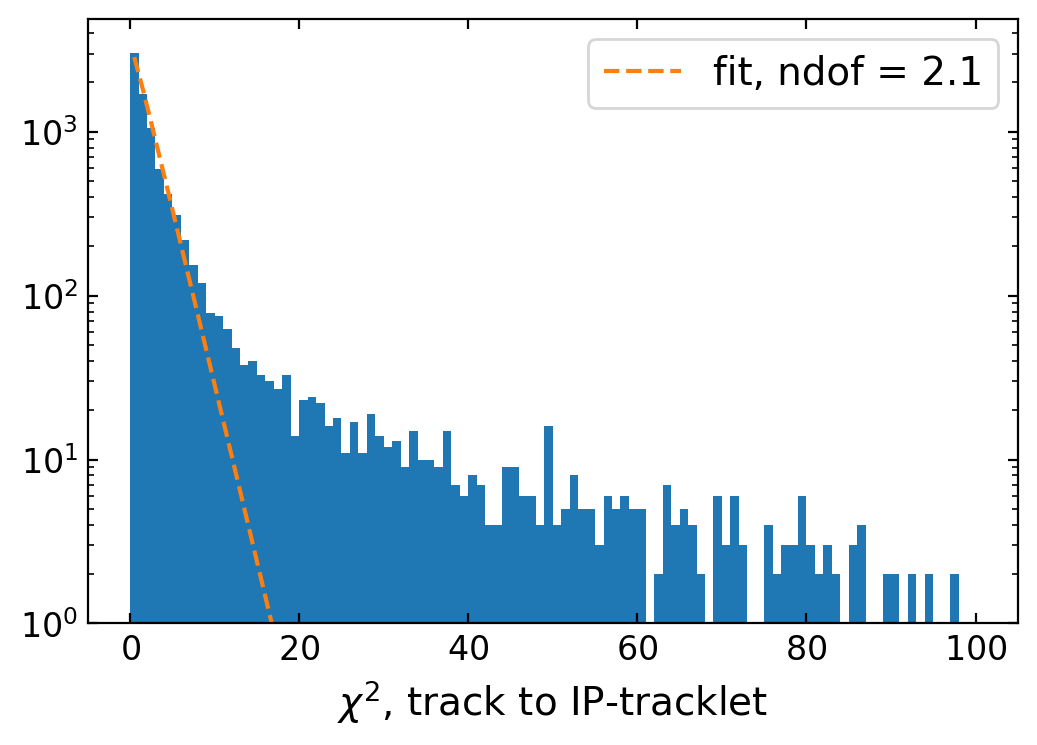

In [19]:
n1,ibins,p = hist(Track_to_IPtrack_chi2_all[Track_to_fwhits_chi2_all>0],range=(0,100),bins=100);
# n2,ibins,p = hist(Track_to_IPtrack_chi2_all[Track_to_fwhits_chi2_all>20],range=(0,100),bins=100);


# Fit for chi2 distribution
x = util.Utils.center(ibins)[:20]
y = n1 [:20]
yerr = np.sqrt(y)
yerr[yerr==0]=1
ndof_start=3
# our line model
def line(x, ndof, A):
    return scipy.stats.chi2.pdf(x, ndof)*A
# Cost function
least_squares = iminuit.cost.LeastSquares(x, y, yerr, line)
# Minimize
m = iminuit.Minuit(least_squares, ndof = ndof_start, A=max(y))  # starting values for α and β
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# Plot
plot(x, line(x, *m.values),label=f"fit, ndof = {m.values[0]:.1f}", color="C1", linestyle="--")

yscale("log")
ylim(bottom=1)
legend()
xlabel(r"$\chi^2$, track to IP-tracklet")

In [ ]:
np.mean(Track_to_IPtrack_dist_all[(Track_to_IPtrack_dist_all>0)&(Track_to_IPtrack_dist_all<14)])

Text(0.5, 0, 'Distance [cm], track to IP-tracklet')

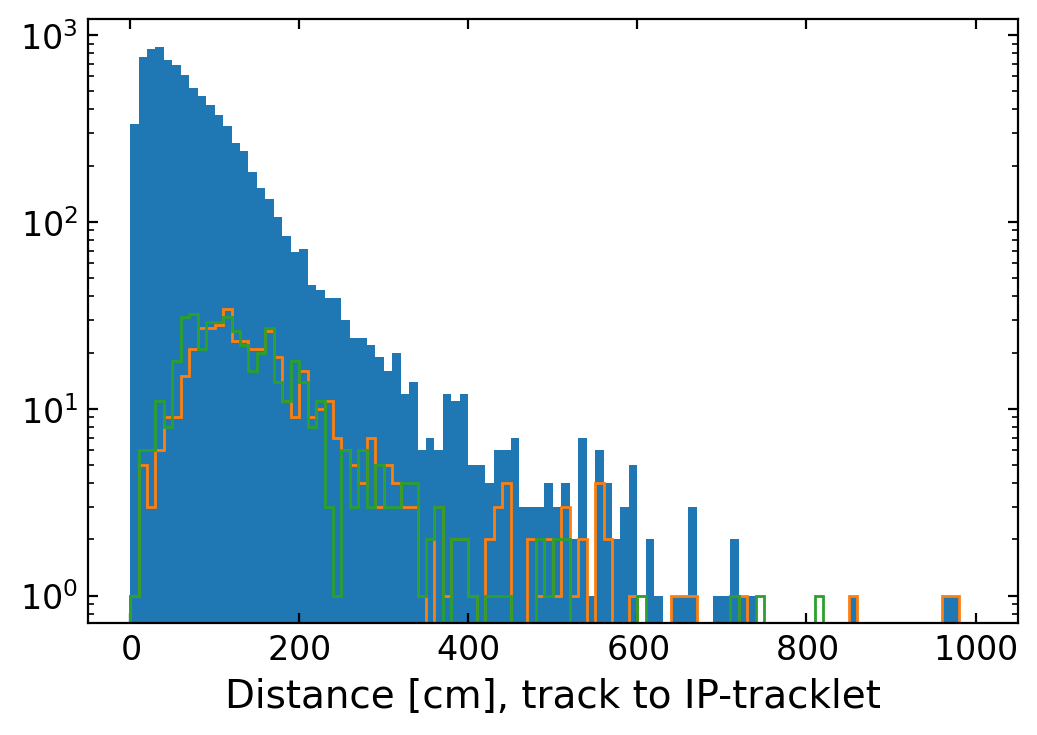

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [16]:
bins=np.linspace(0,1000,101)
hist(Track_to_IPtrack_dist_all[Track_to_fwhits_chi2_all>0], bins=bins);
hist(Track_to_IPtrack_dist_all[Track_to_fwhits_chi2_all>20], bins=bins,histtype="step");
hist(Track_to_IPtrack_dist2_all[Track_to_fwhits_chi2_all>20], bins=bins,histtype="step");
# hist(Track_to_IPtrack_dist_all[Track_to_fwhits_chi2_all>20]);
yscale("log")
xlabel("Distance [cm], track to IP-tracklet")

In [21]:
sum( ((Track_to_IPtrack_dist2_all<400)|(Track_to_fwhits_chi2_all<20)|(Track_to_fwhits_dist_all<400)|(Track_to_IPtrack_chi2_all<20)) &(Track_to_fwhits_chi2_all>0))  /  sum(Track_to_fwhits_chi2_all>0)

0.9984027381631488

Text(0.5, 0, 'Track deflection in the earth [$^\\circ$]')

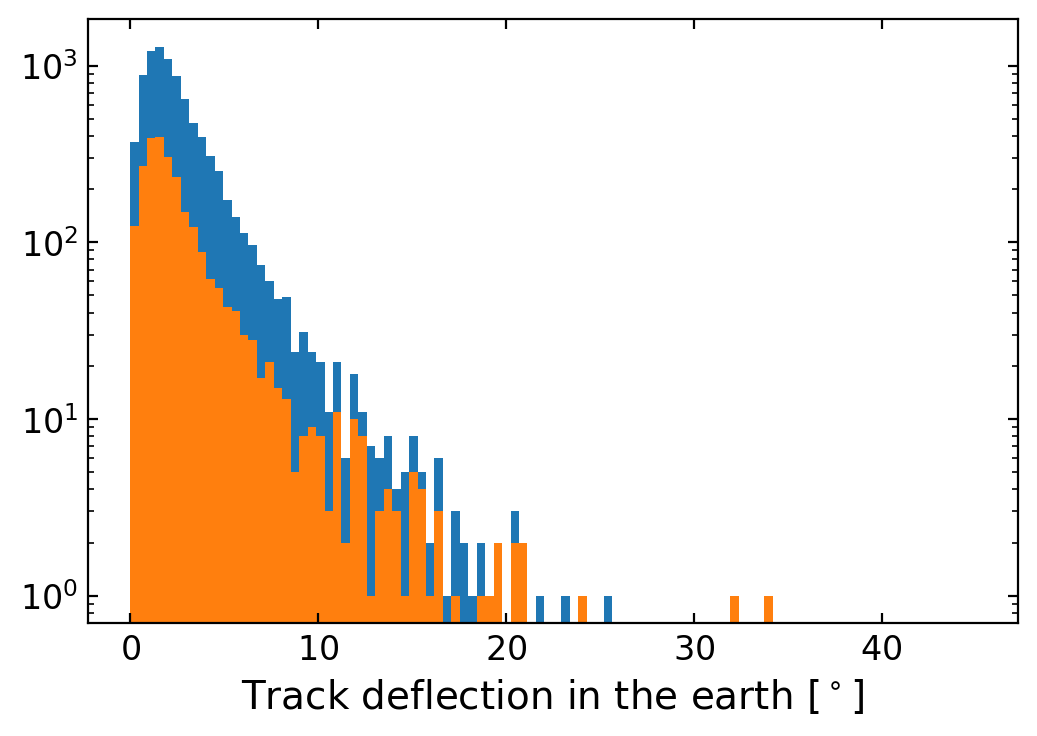

In [64]:
hist(Track_deflection_all[Track_to_IPtrack_chi2_all>0]/np.pi*180, range=(0,45));
hist(Track_deflection_all[Track_to_IPtrack_chi2_all>50]/np.pi*180, range=(0,45));
yscale("log")
xlabel(r"Track deflection in the earth [$^\circ$]")

---
# IP track fitting debug

 10%|█         | 3/30 [00:00<00:01, 24.25it/s]

Chi2: 598.0220439643404
 Distance: 75.54140623436045
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  3.97661022e-03
   4.25646481e-04  6.44646043e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00  8.40783171e-05
   5.76661849e-04 -3.61185825e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.80010251e+02  6.87661604e-02
  -1.95051452e-01  1.44796118e-01  0.00000000e+00]
 [ 3.97661022e-03  8.40783171e-05  6.87661604e-02  3.56616591e-05
  -7.33635928e-05  5.67419337e-05  0.00000000e+00]
 [ 4.25646481e-04  5.76661849e-04 -1.95051452e-01 -7.33635928e-05
   2.12454439e-04 -1.57357160e-04  0.00000000e+00]
 [ 6.44646043e-04 -3.61185825e-04  1.44796118e-01  5.67419337e-05
  -1.57357160e-04  1.17108306e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.68269737e+00  0.00000000e+00 -1.93113053e-02 -3.65246912e-02
  -8.95914470e-04 -8.21186280e-04 -1.22776893e-03]
 [ 0.00000

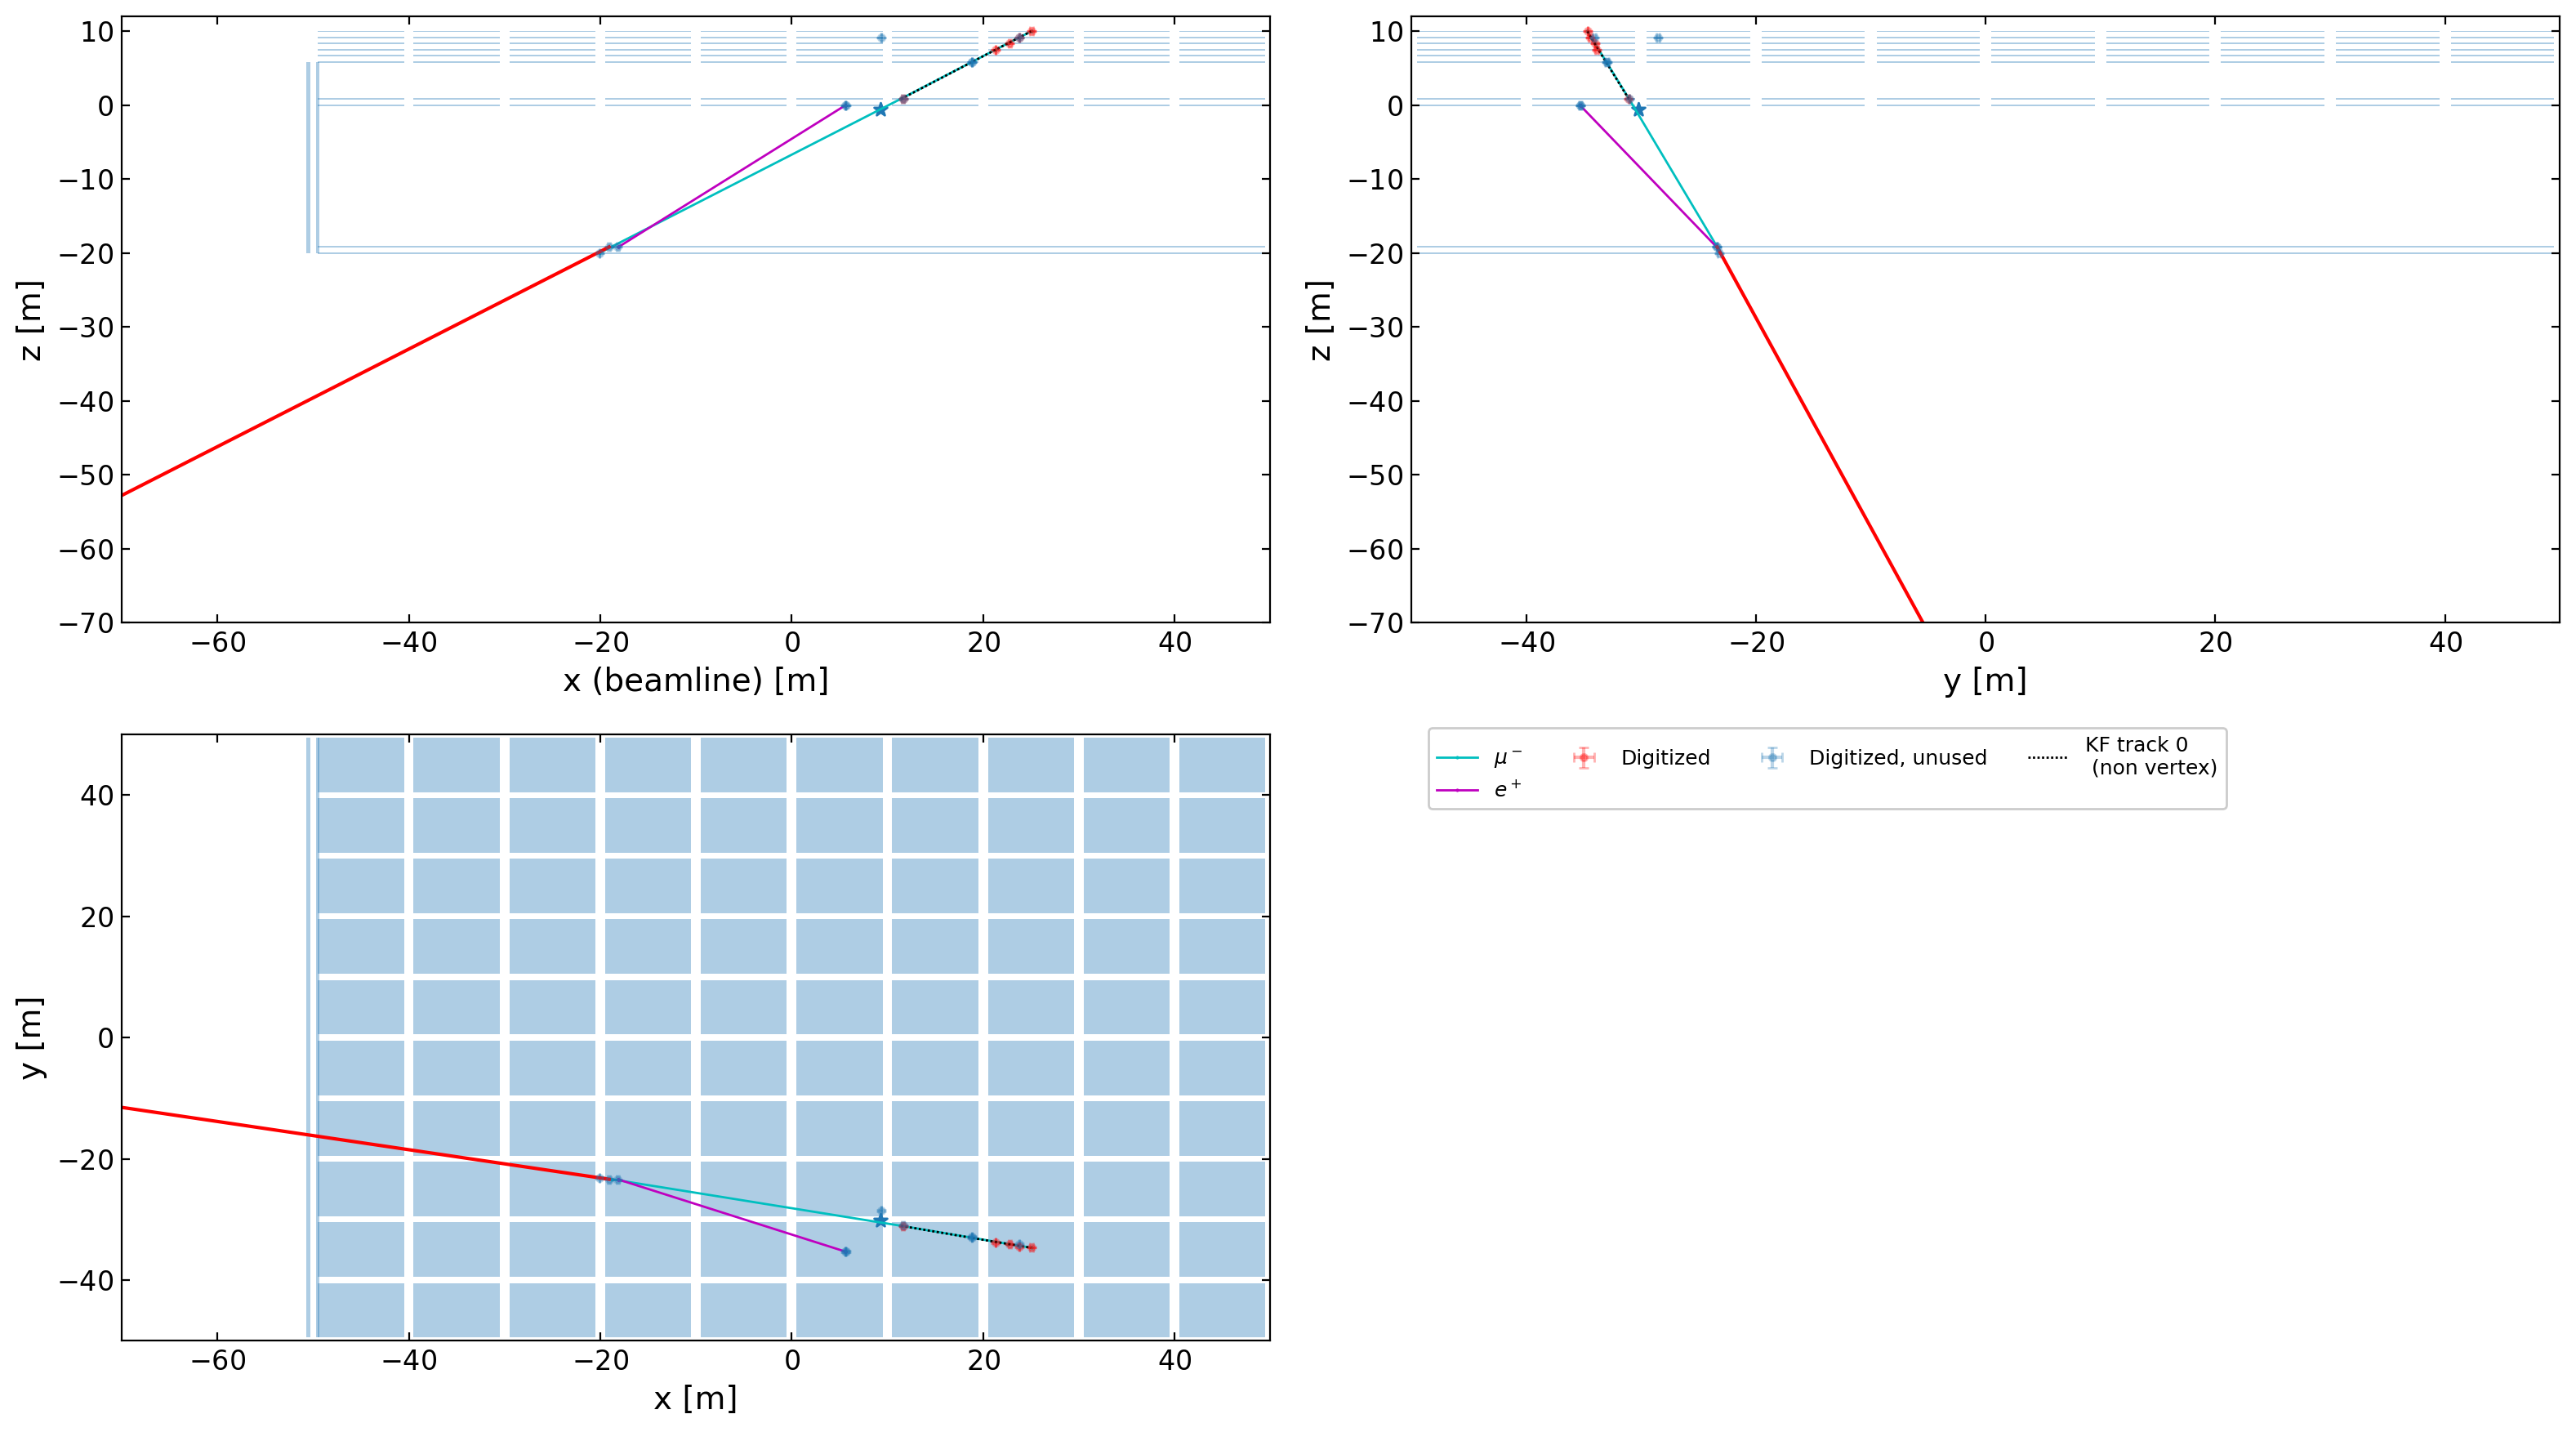

Chi2: 191.64173737283687
 Distance: 104.9320063377809
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  3.95377628e-03
   4.18769820e-04  6.39911617e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00  8.27199645e-05
   5.76032358e-04 -3.57844370e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.80010251e+02  6.82611262e-02
  -1.93246964e-01  1.42243702e-01  0.00000000e+00]
 [ 3.95377628e-03  8.27199645e-05  6.82611262e-02  3.51692297e-05
  -7.21564622e-05  5.53502875e-05  0.00000000e+00]
 [ 4.18769820e-04  5.76032358e-04 -1.93246964e-01 -7.21564622e-05
   2.08556376e-04 -1.53162913e-04  0.00000000e+00]
 [ 6.39911617e-04 -3.57844370e-04  1.42243702e-01  5.53502875e-05
  -1.53162913e-04  1.13027475e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.68269737e+00  0.00000000e+00 -1.93113053e-02 -3.65246912e-02
  -8.95914470e-04 -8.21186280e-04 -1.22776893e-03]
 [ 0.0000

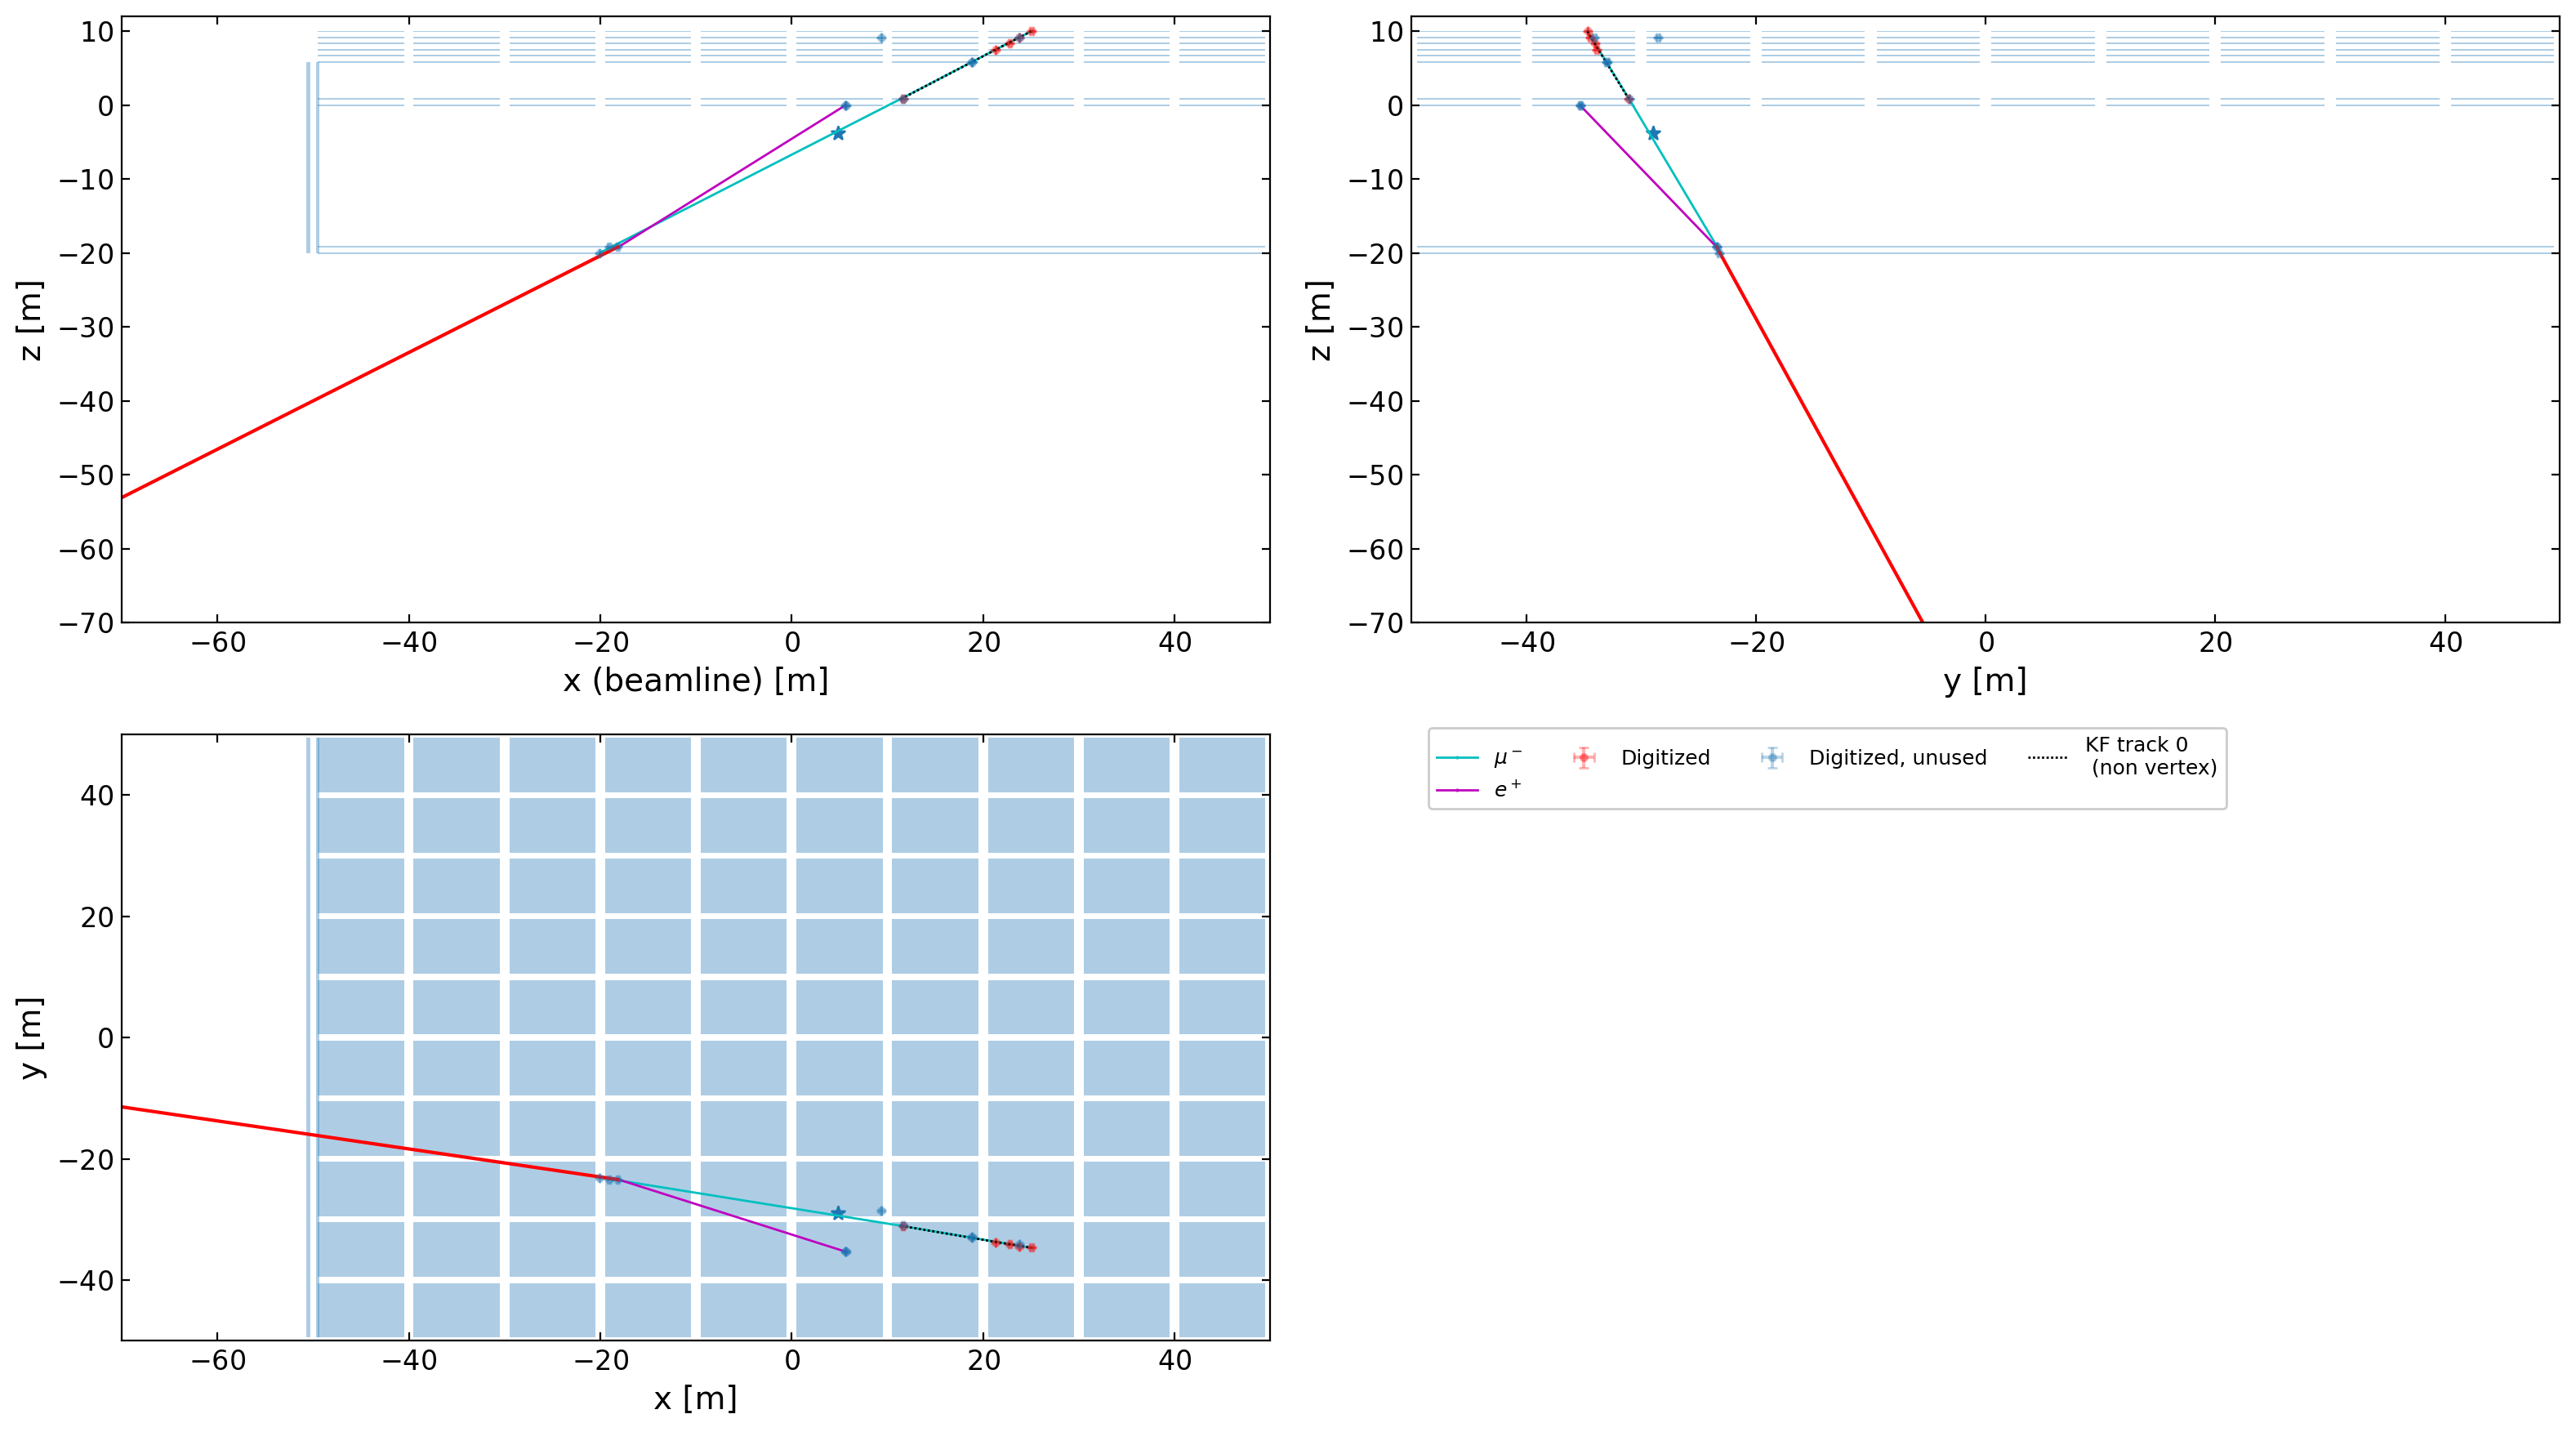

 33%|███▎      | 10/30 [00:05<00:11,  1.81it/s]

Chi2: 46.66615171683204
 Distance: 80.46985695058613
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  3.97174495e-03
  -4.05905293e-04 -6.19611372e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00 -8.01788233e-05
   5.76244566e-04 -3.59619614e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.80010251e+02 -6.60956434e-02
  -1.94205651e-01  1.41959782e-01  0.00000000e+00]
 [ 3.97174495e-03 -8.01788233e-05 -6.60956434e-02  3.36360980e-05
   7.02139121e-05 -5.34962144e-05  0.00000000e+00]
 [-4.05905293e-04  5.76244566e-04 -1.94205651e-01  7.02139121e-05
   2.10614292e-04 -1.53627213e-04  0.00000000e+00]
 [-6.19611372e-04 -3.59619614e-04  1.41959782e-01 -5.34962144e-05
  -1.53627213e-04  1.12567886e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.98874811e+00  0.00000000e+00  1.51698642e-03 -3.20236968e-02
   3.20688601e-05  3.10063195e-04  1.51987989e-03]
 [ 0.00000

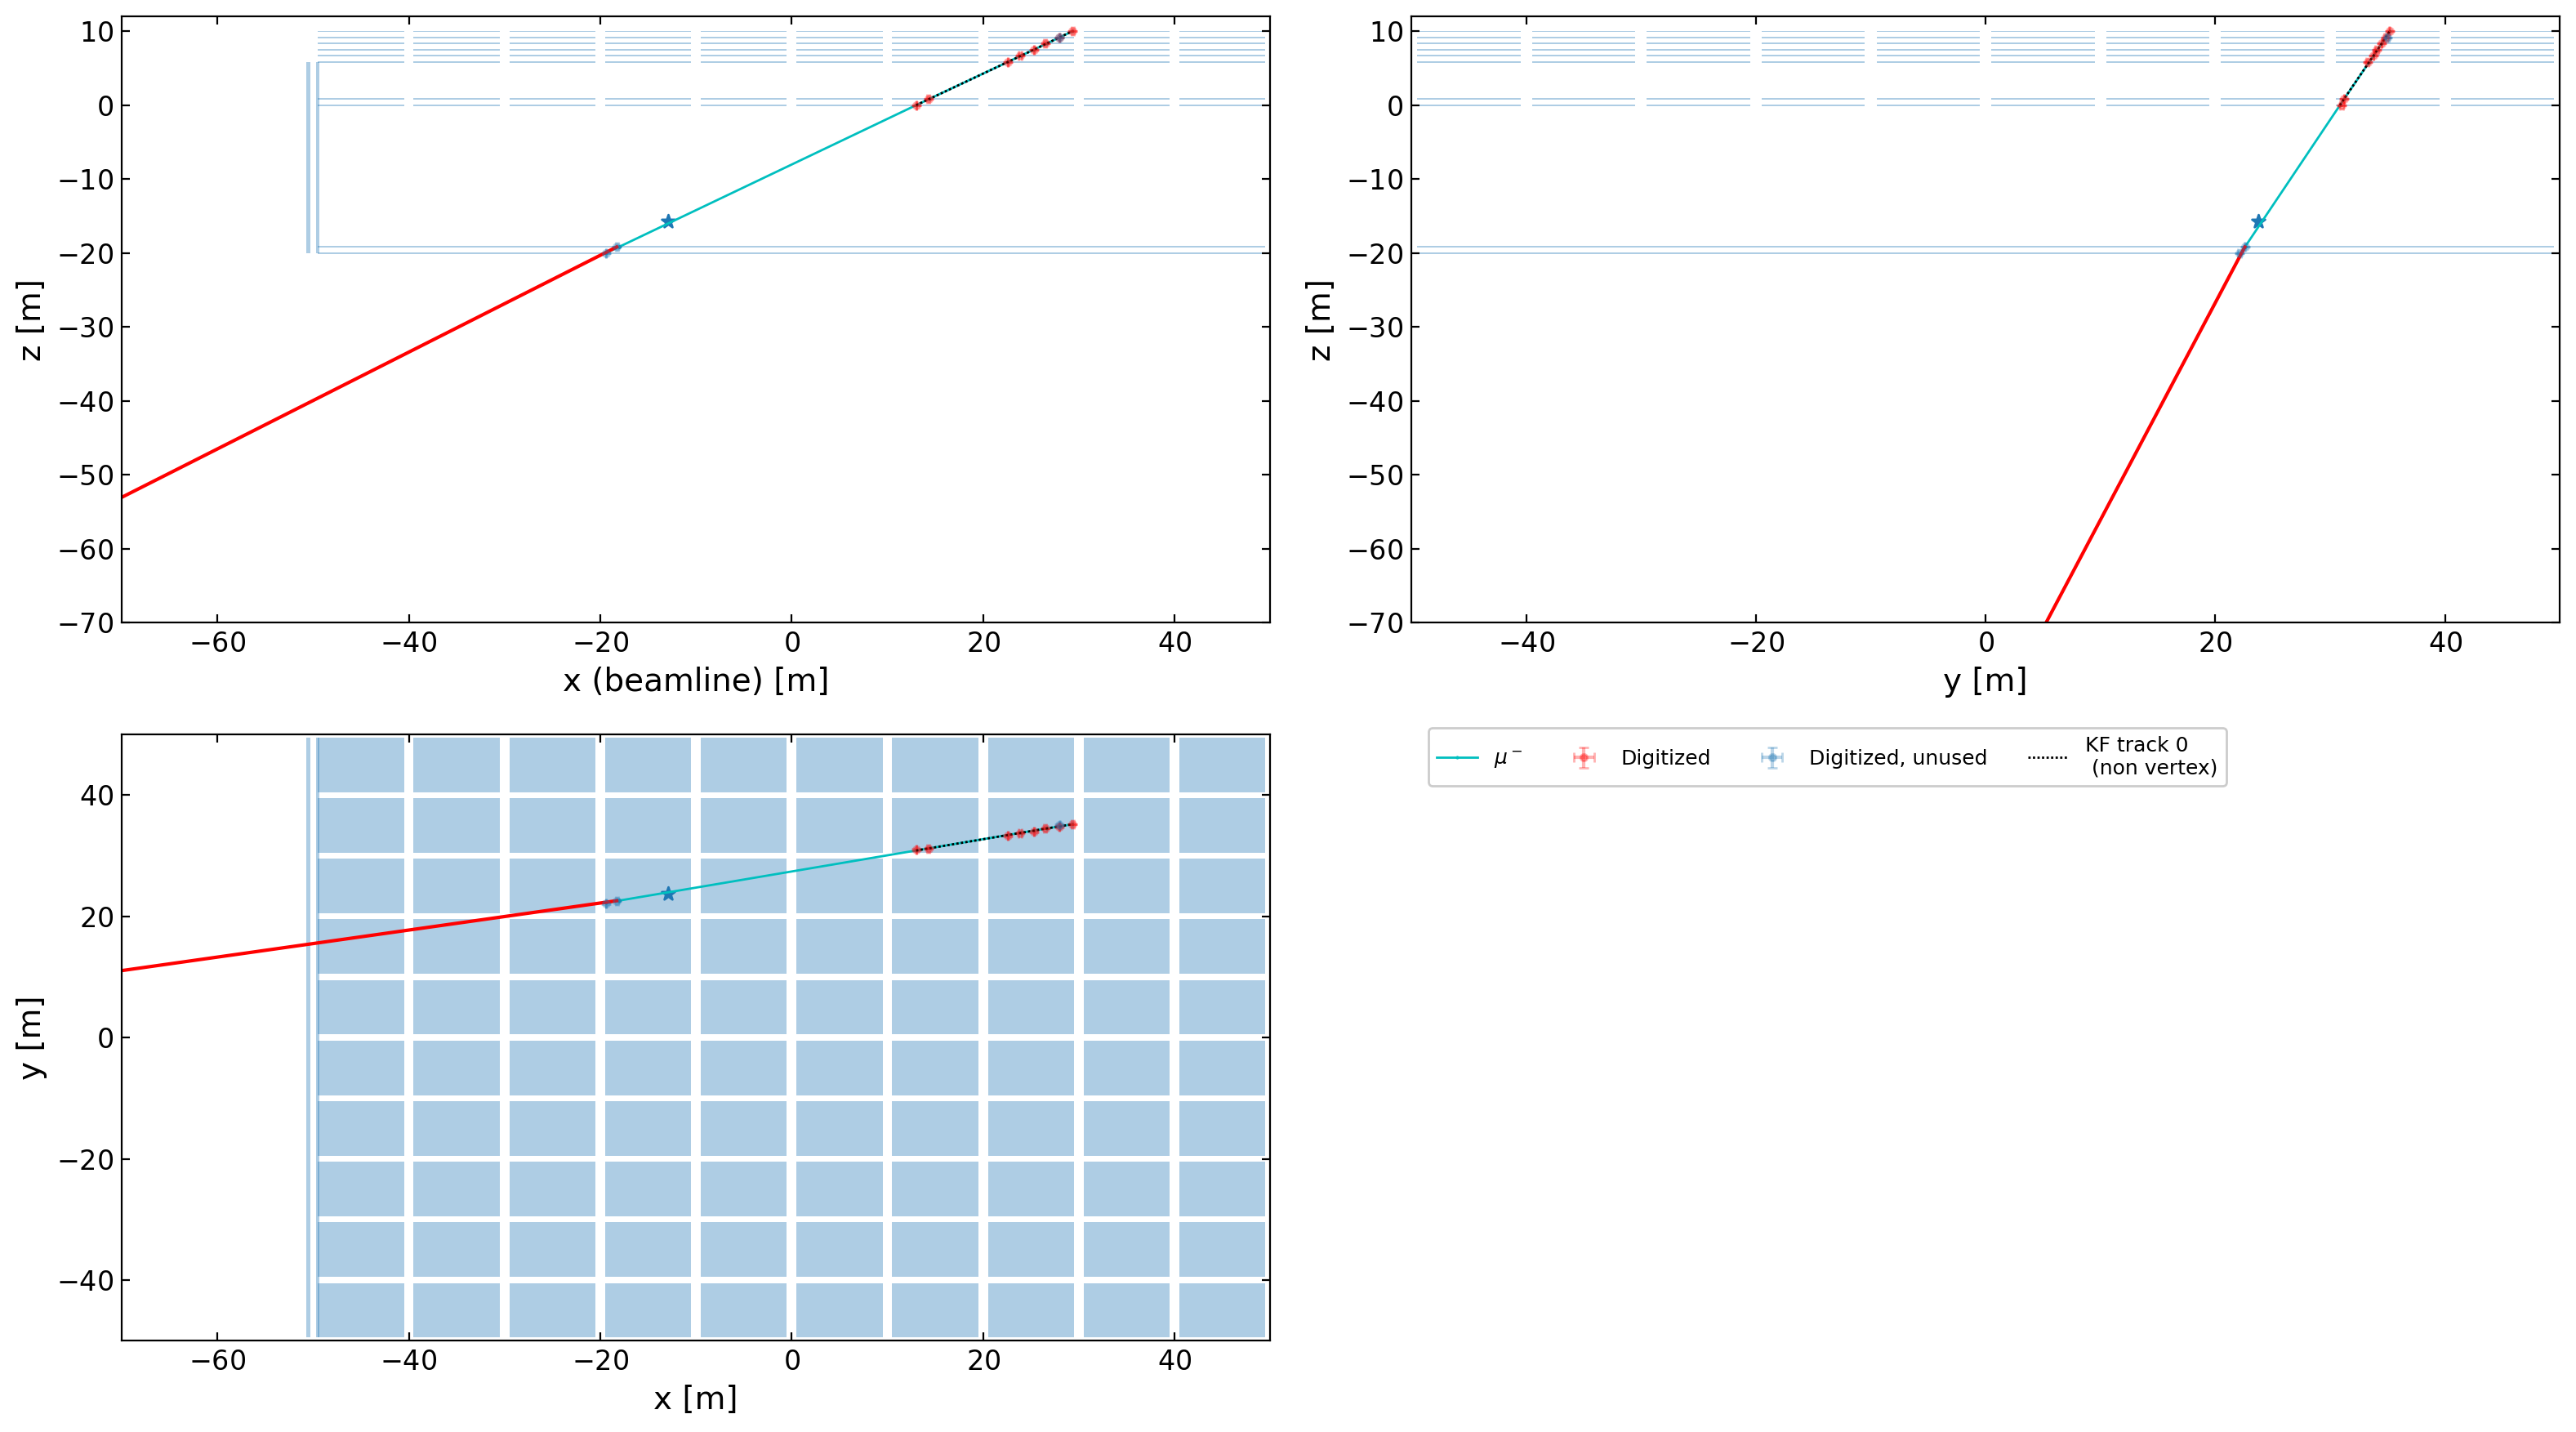

 43%|████▎     | 13/30 [00:07<00:10,  1.57it/s]

Chi2: 47.432027924849855
 Distance: 39.078375877453546
[[ 1.80010251e+02  0.00000000e+00  0.00000000e+00  4.45879865e-01
  -4.18853985e-02 -6.13684444e-02  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00 -7.75611359e-05
   5.86192362e-04 -3.84442046e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.68750000e+00 -5.75296405e-04
  -1.94623786e-03  1.44441883e-03  0.00000000e+00]
 [ 4.45879865e-01 -7.75611359e-05 -5.75296405e-04  1.10464492e-03
  -1.03221739e-04 -1.52410726e-04  0.00000000e+00]
 [-4.18853985e-02  5.86192362e-04 -1.94623786e-03 -1.03221739e-04
   1.30215487e-05  1.19374618e-05  0.00000000e+00]
 [-6.13684444e-02 -3.84442046e-04  1.44441883e-03 -1.52410726e-04
   1.19374618e-05  2.26012485e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.98634453e+00  0.00000000e+00  1.36564055e-03 -3.49475071e-02
  -2.97846800e-05  4.26376696e-04  9.89416622e-04]
 [ 0.000

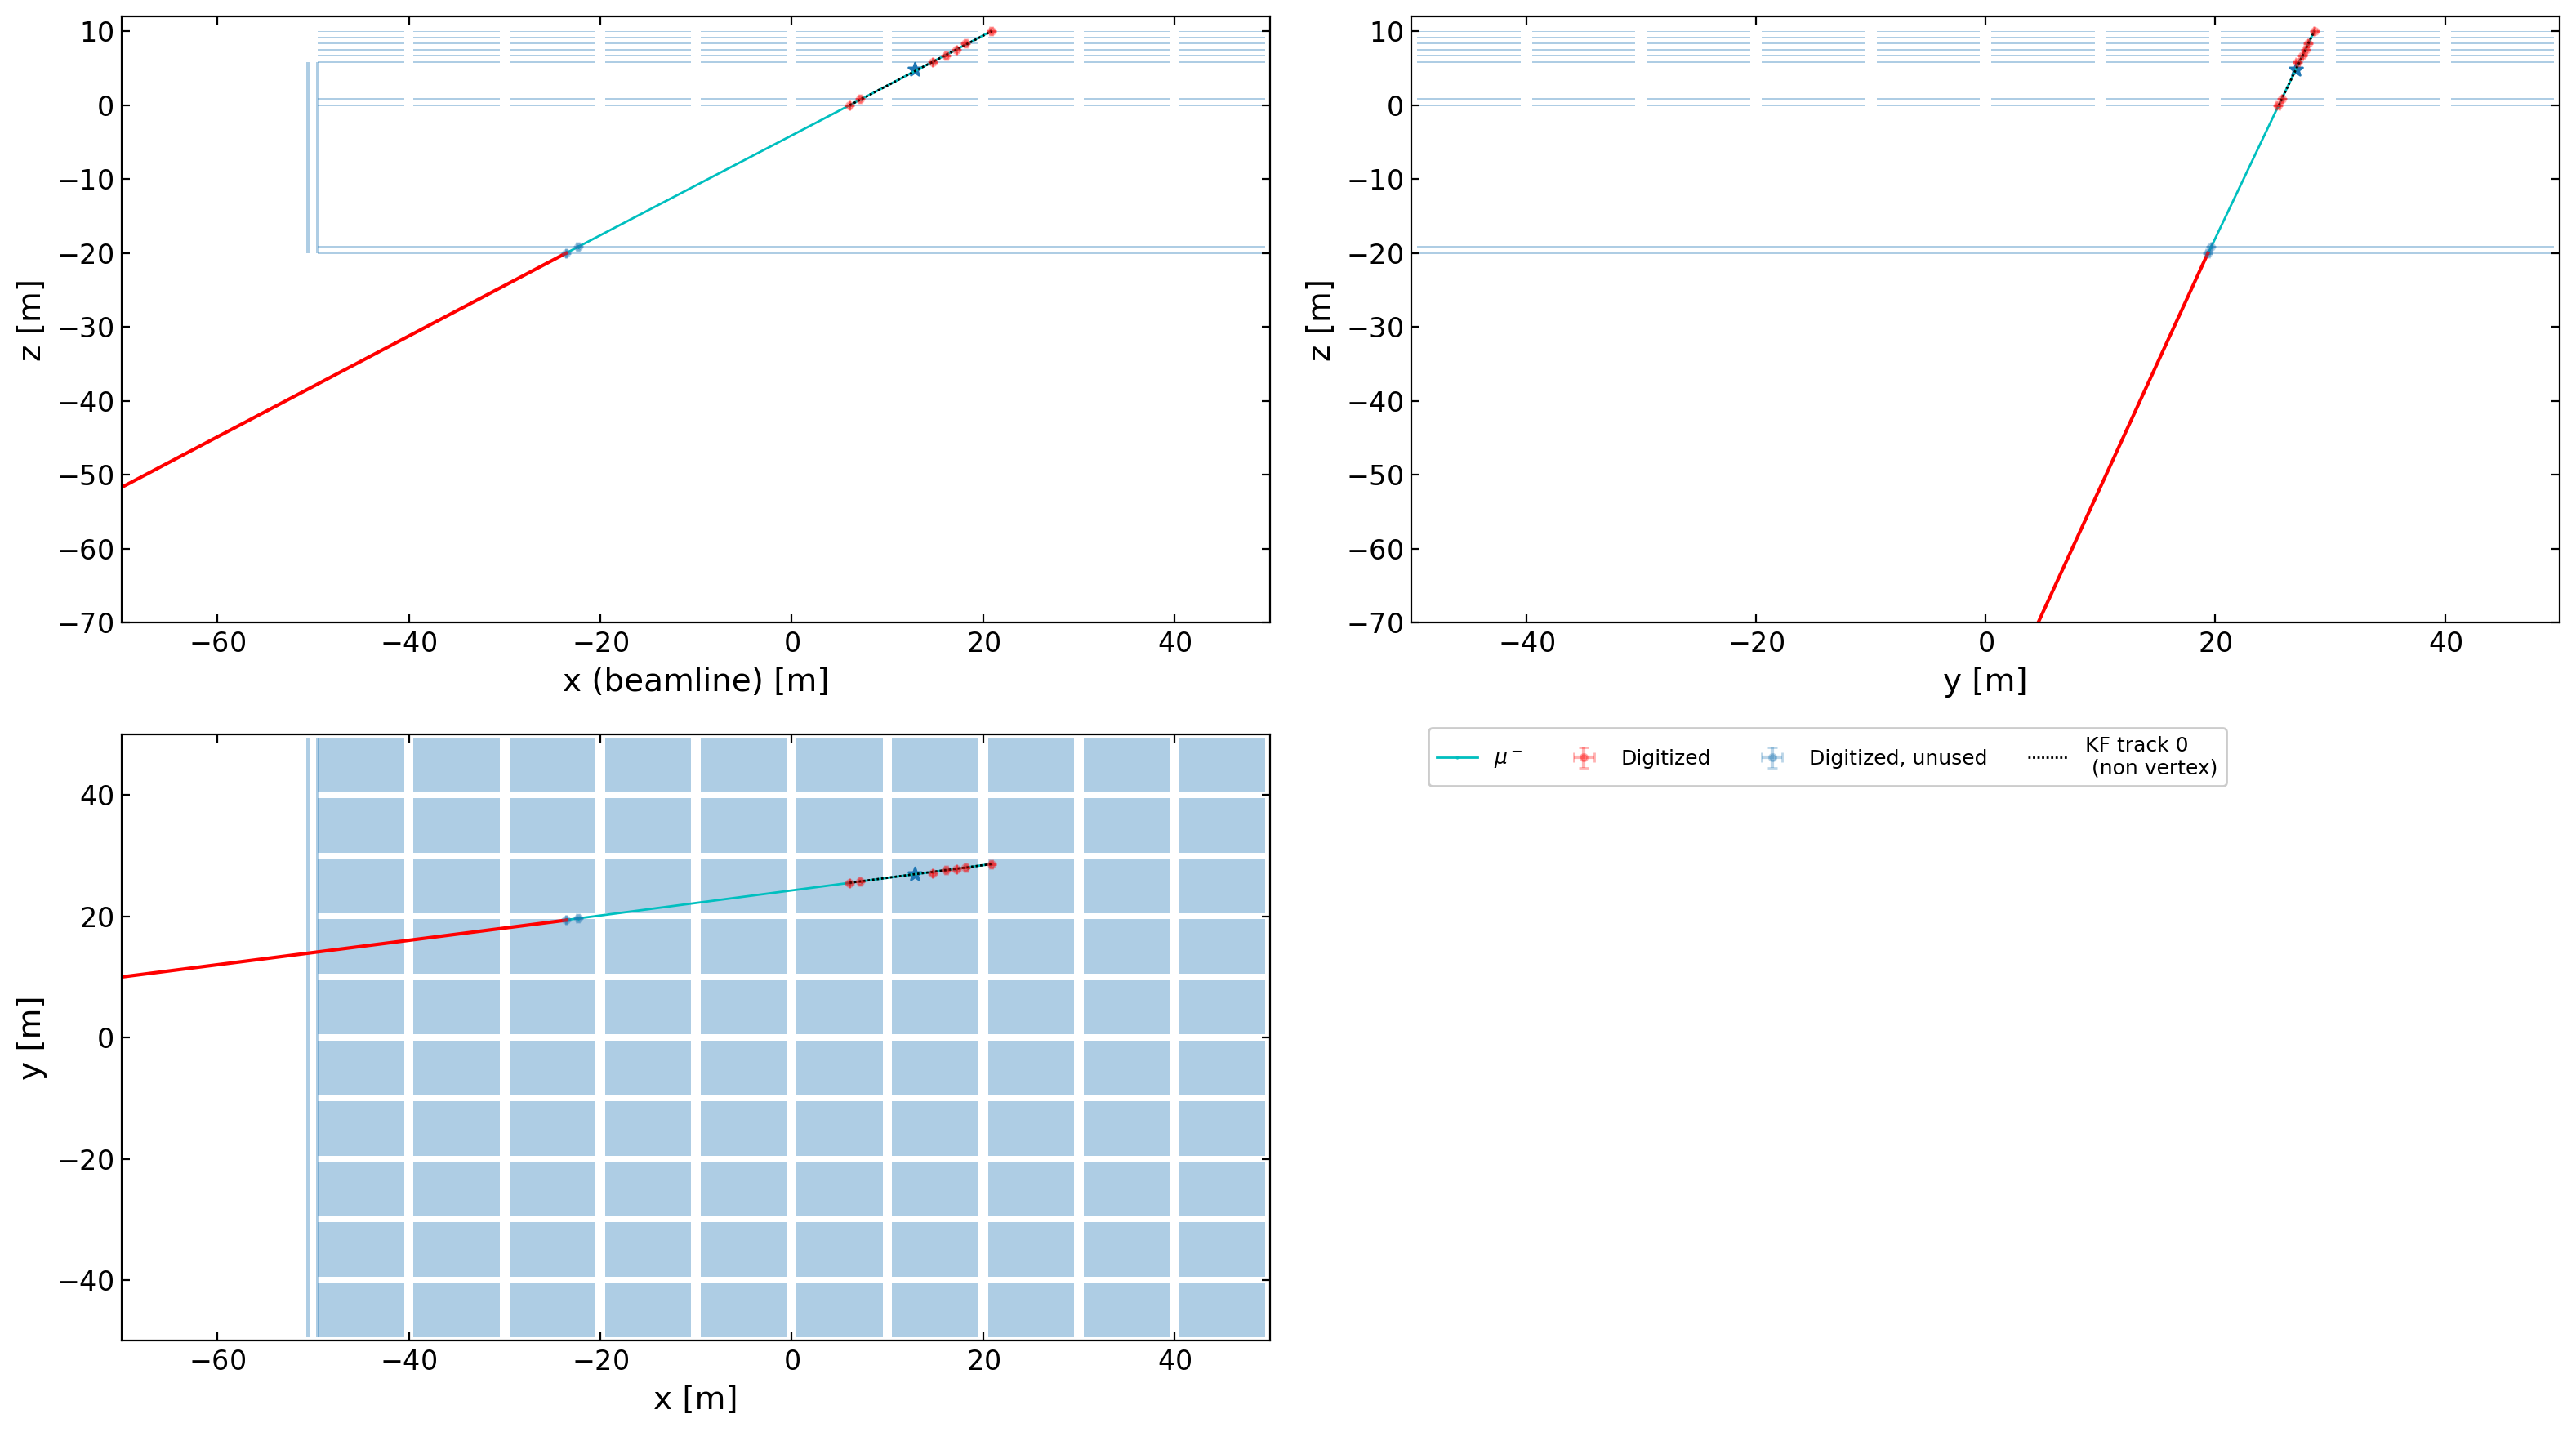

Chi2: 169.2500137866756
 Distance: 58.5327311275694
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  4.12692918e-03
  -3.88473163e-04 -5.69209718e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00 -7.67354395e-05
   5.78884073e-04 -3.79562227e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.80010251e+02 -6.07191608e-02
  -2.04975275e-01  1.52166622e-01  0.00000000e+00]
 [ 4.12692918e-03 -7.67354395e-05 -6.07191608e-02  3.05915796e-05
   6.80567918e-05 -5.26319162e-05  0.00000000e+00]
 [-3.88473163e-04  5.78884073e-04 -2.04975275e-01  6.80567918e-05
   2.34497365e-04 -1.73798238e-04  0.00000000e+00]
 [-5.69209718e-04 -3.79562227e-04  1.52166622e-01 -5.26319162e-05
  -1.73798238e-04  1.29253994e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.98634453e+00  0.00000000e+00  1.36564055e-03 -3.49475071e-02
  -2.97846800e-05  4.26376696e-04  9.89416622e-04]
 [ 0.000000

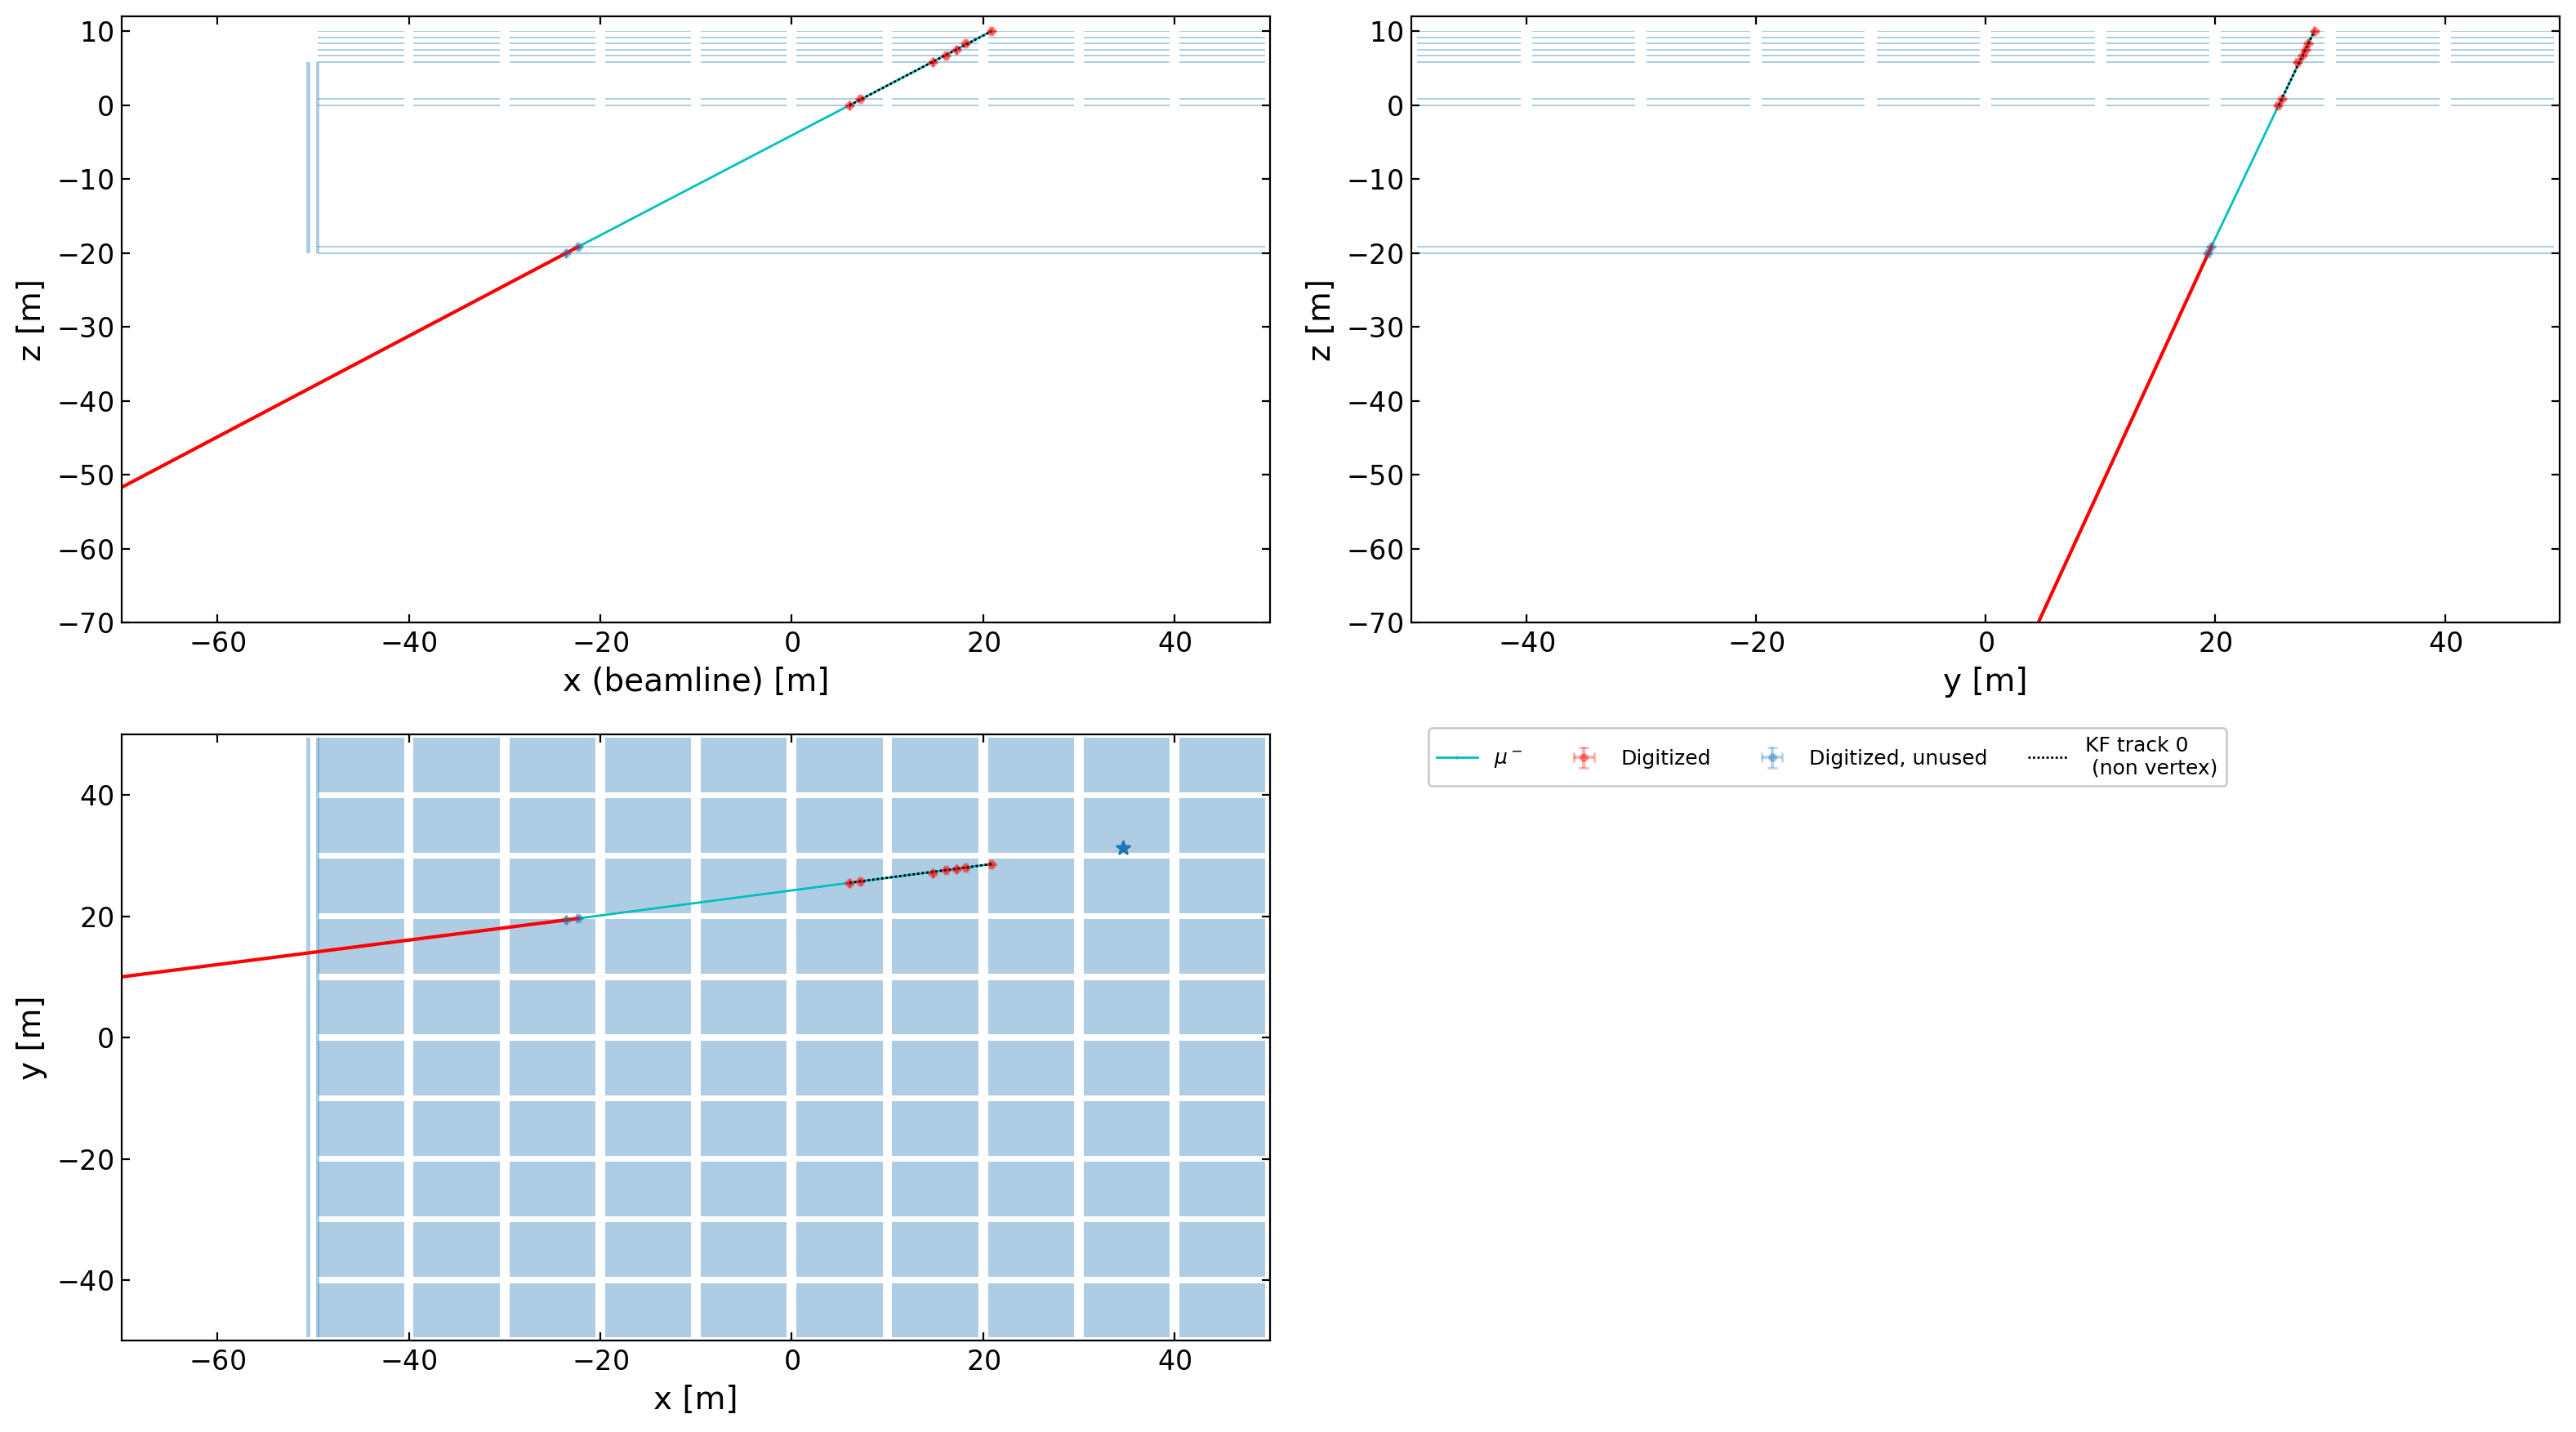

 53%|█████▎    | 16/30 [00:14<00:15,  1.12s/it]

Chi2: 71.90298137526196
 Distance: 108.43186332644984
[[ 1.80010251e+02  0.00000000e+00  0.00000000e+00  5.52658005e-01
   8.74661077e-03  8.73548756e-03  0.00000000e+00]
 [ 0.00000000e+00  1.68750000e+00  0.00000000e+00  8.19948066e-05
   2.58973255e-03 -2.59043478e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-01  1.61759076e-05
  -5.11690821e-04  5.12854390e-04  0.00000000e+00]
 [ 5.52658005e-01  8.19948066e-05  1.61759076e-05  1.69674631e-03
   2.69543871e-05  2.67182542e-05  0.00000000e+00]
 [ 8.74661077e-03  2.58973255e-03 -5.11690821e-04  2.69543871e-05
   5.18482552e-06 -4.33824268e-06  0.00000000e+00]
 [ 8.73548756e-03 -2.59043478e-03  5.12854390e-04  2.67182542e-05
  -4.33824268e-06  5.18947730e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.97607803e+00  0.00000000e+00 -1.26350637e-04 -4.52917094e-02
   4.88787292e-05 -8.95647004e-05 -7.44818258e-05]
 [ 0.0000

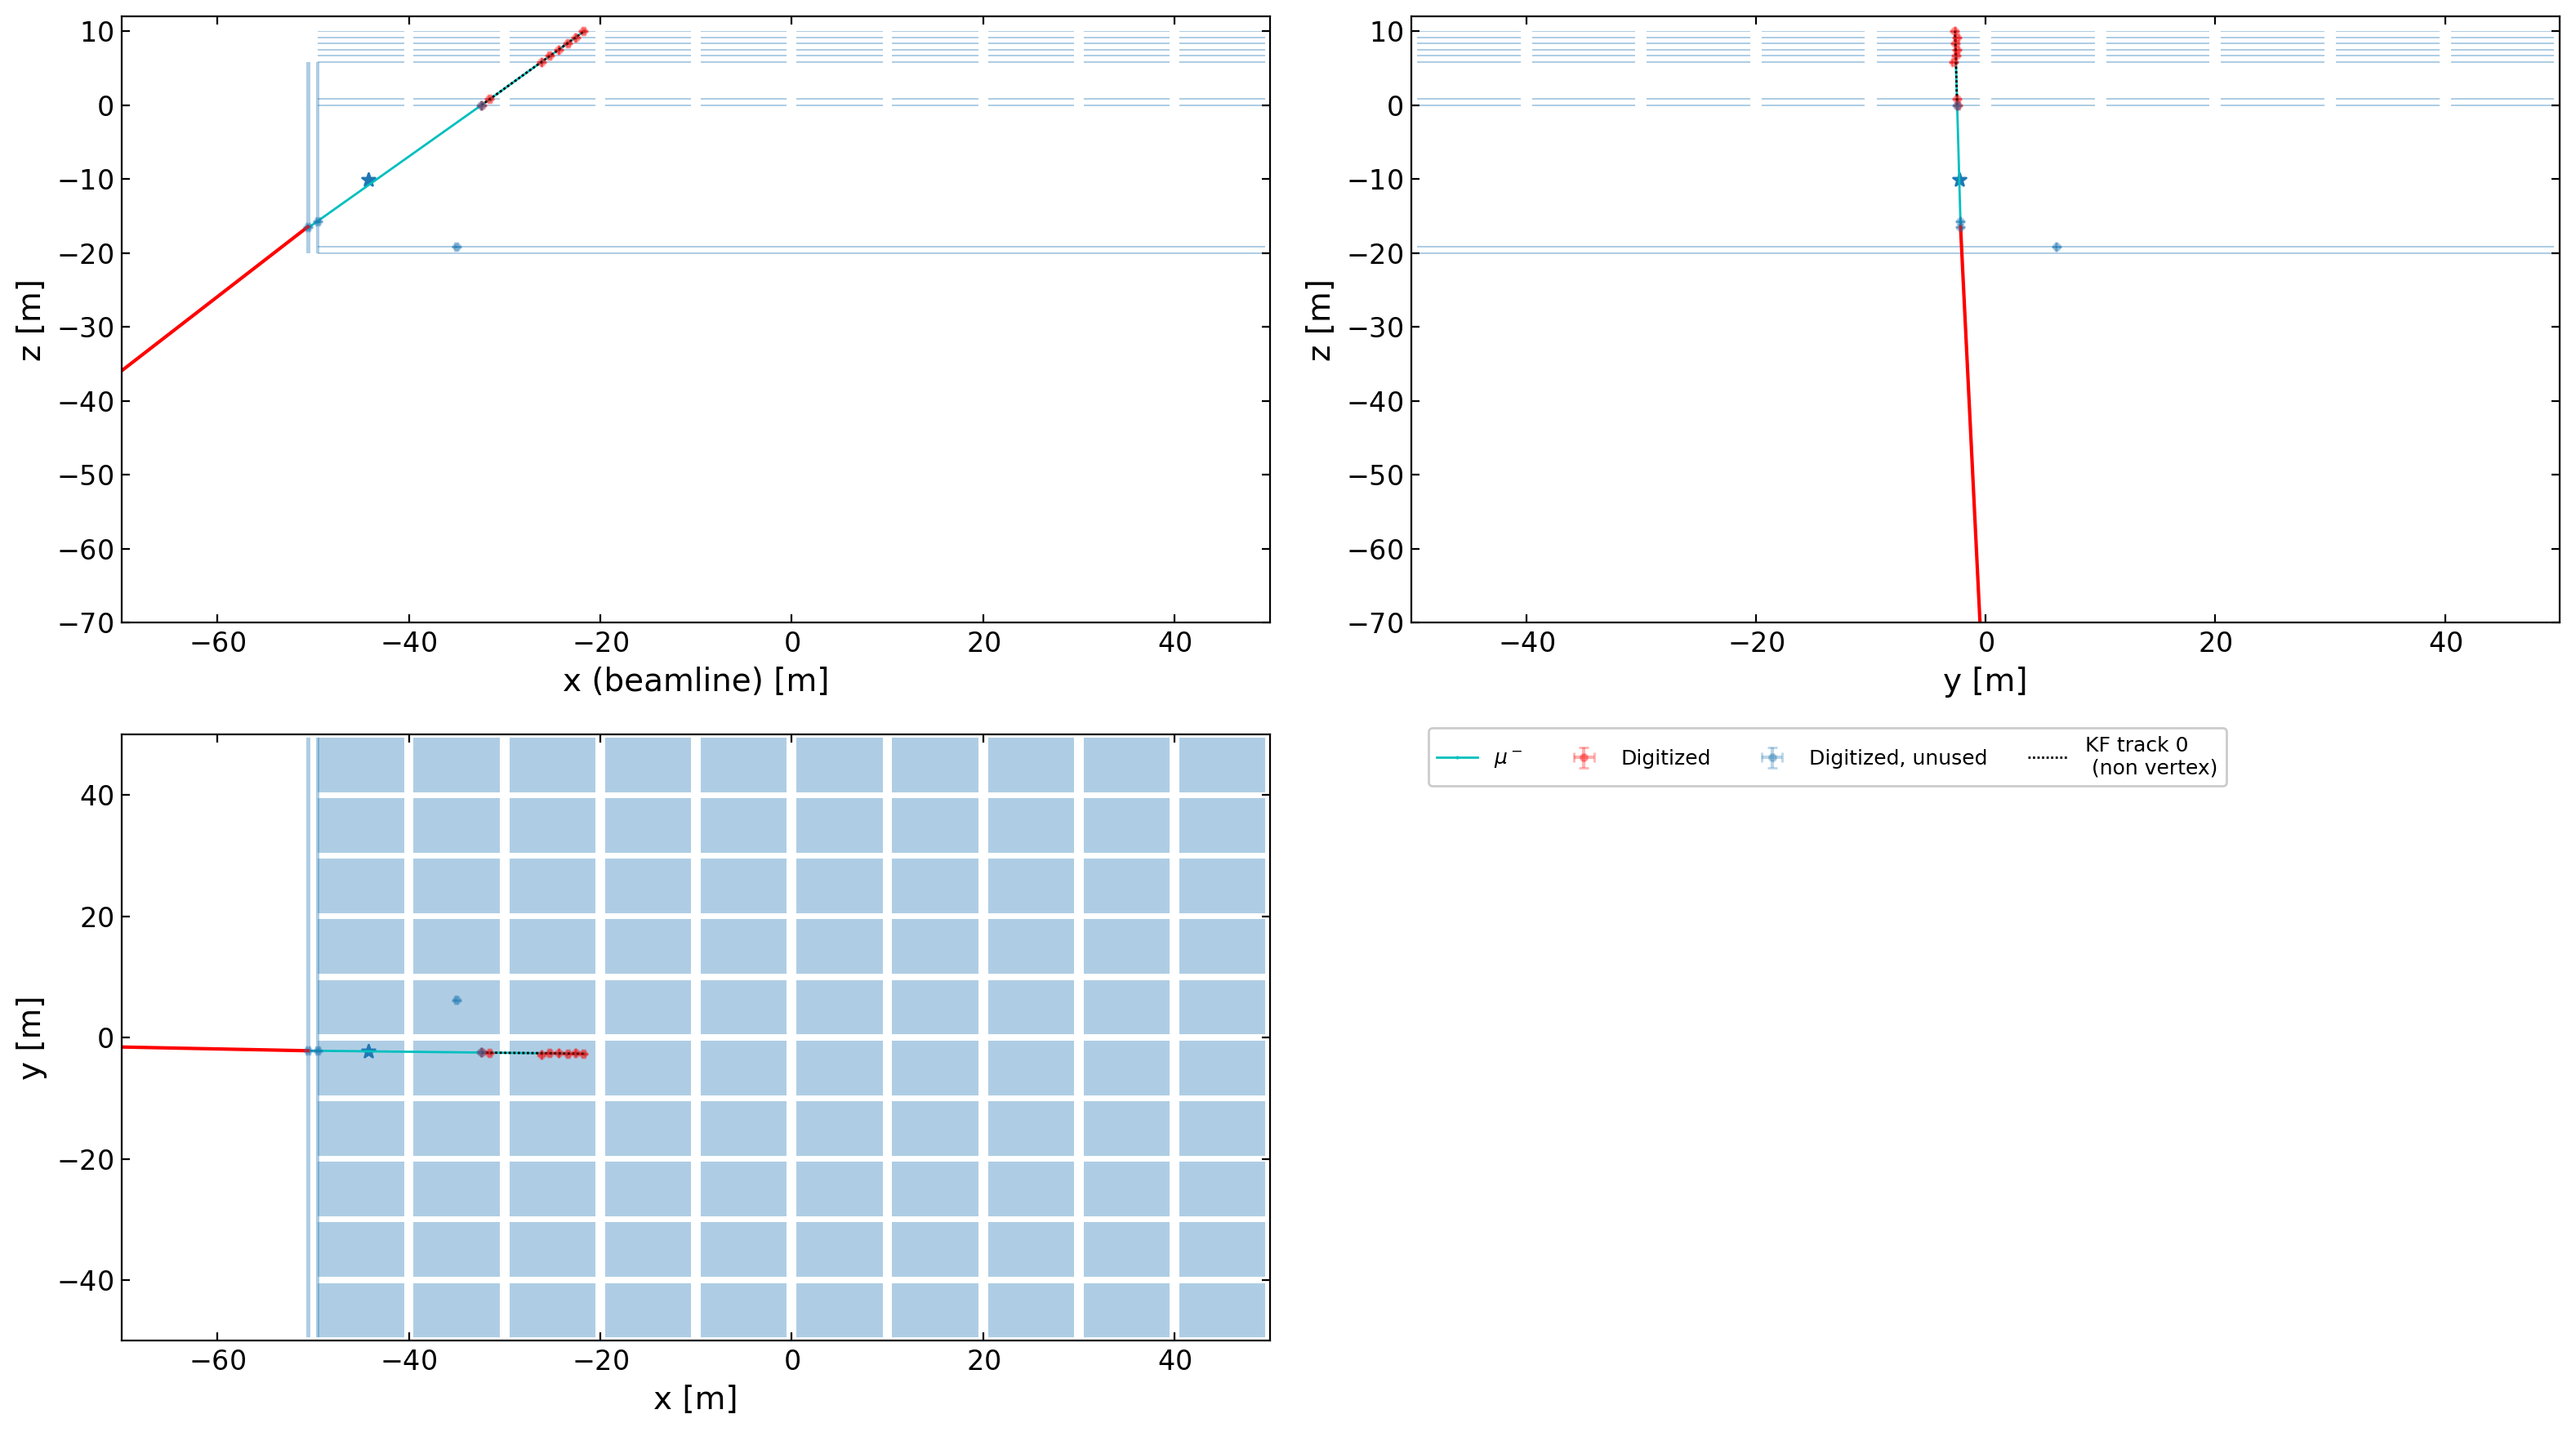

Chi2: 30.194754219990276
 Distance: 81.68180961254919
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  5.11437662e-03
   8.05485330e-05  8.07441133e-05  0.00000000e+00]
 [ 0.00000000e+00  1.80010251e+02  0.00000000e+00  8.59233280e-03
   2.73715133e-01 -2.72781484e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-01  1.59494545e-05
  -5.05122132e-04  5.04401004e-04  0.00000000e+00]
 [ 5.11437662e-03  8.59233280e-03  1.59494545e-05  1.59112509e-05
   1.32850503e-05 -1.27516831e-05  0.00000000e+00]
 [ 8.05485330e-05  2.73715133e-01 -5.05122132e-04  1.32850503e-05
   4.16967668e-04 -4.15539213e-04  0.00000000e+00]
 [ 8.07441133e-05 -2.72781484e-01  5.04401004e-04 -1.27516831e-05
  -4.15539213e-04  4.14131019e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.97607803e+00  0.00000000e+00 -1.26350637e-04 -4.52917094e-02
   4.88787292e-05 -8.95647004e-05 -7.44818258e-05]
 [ 0.0000

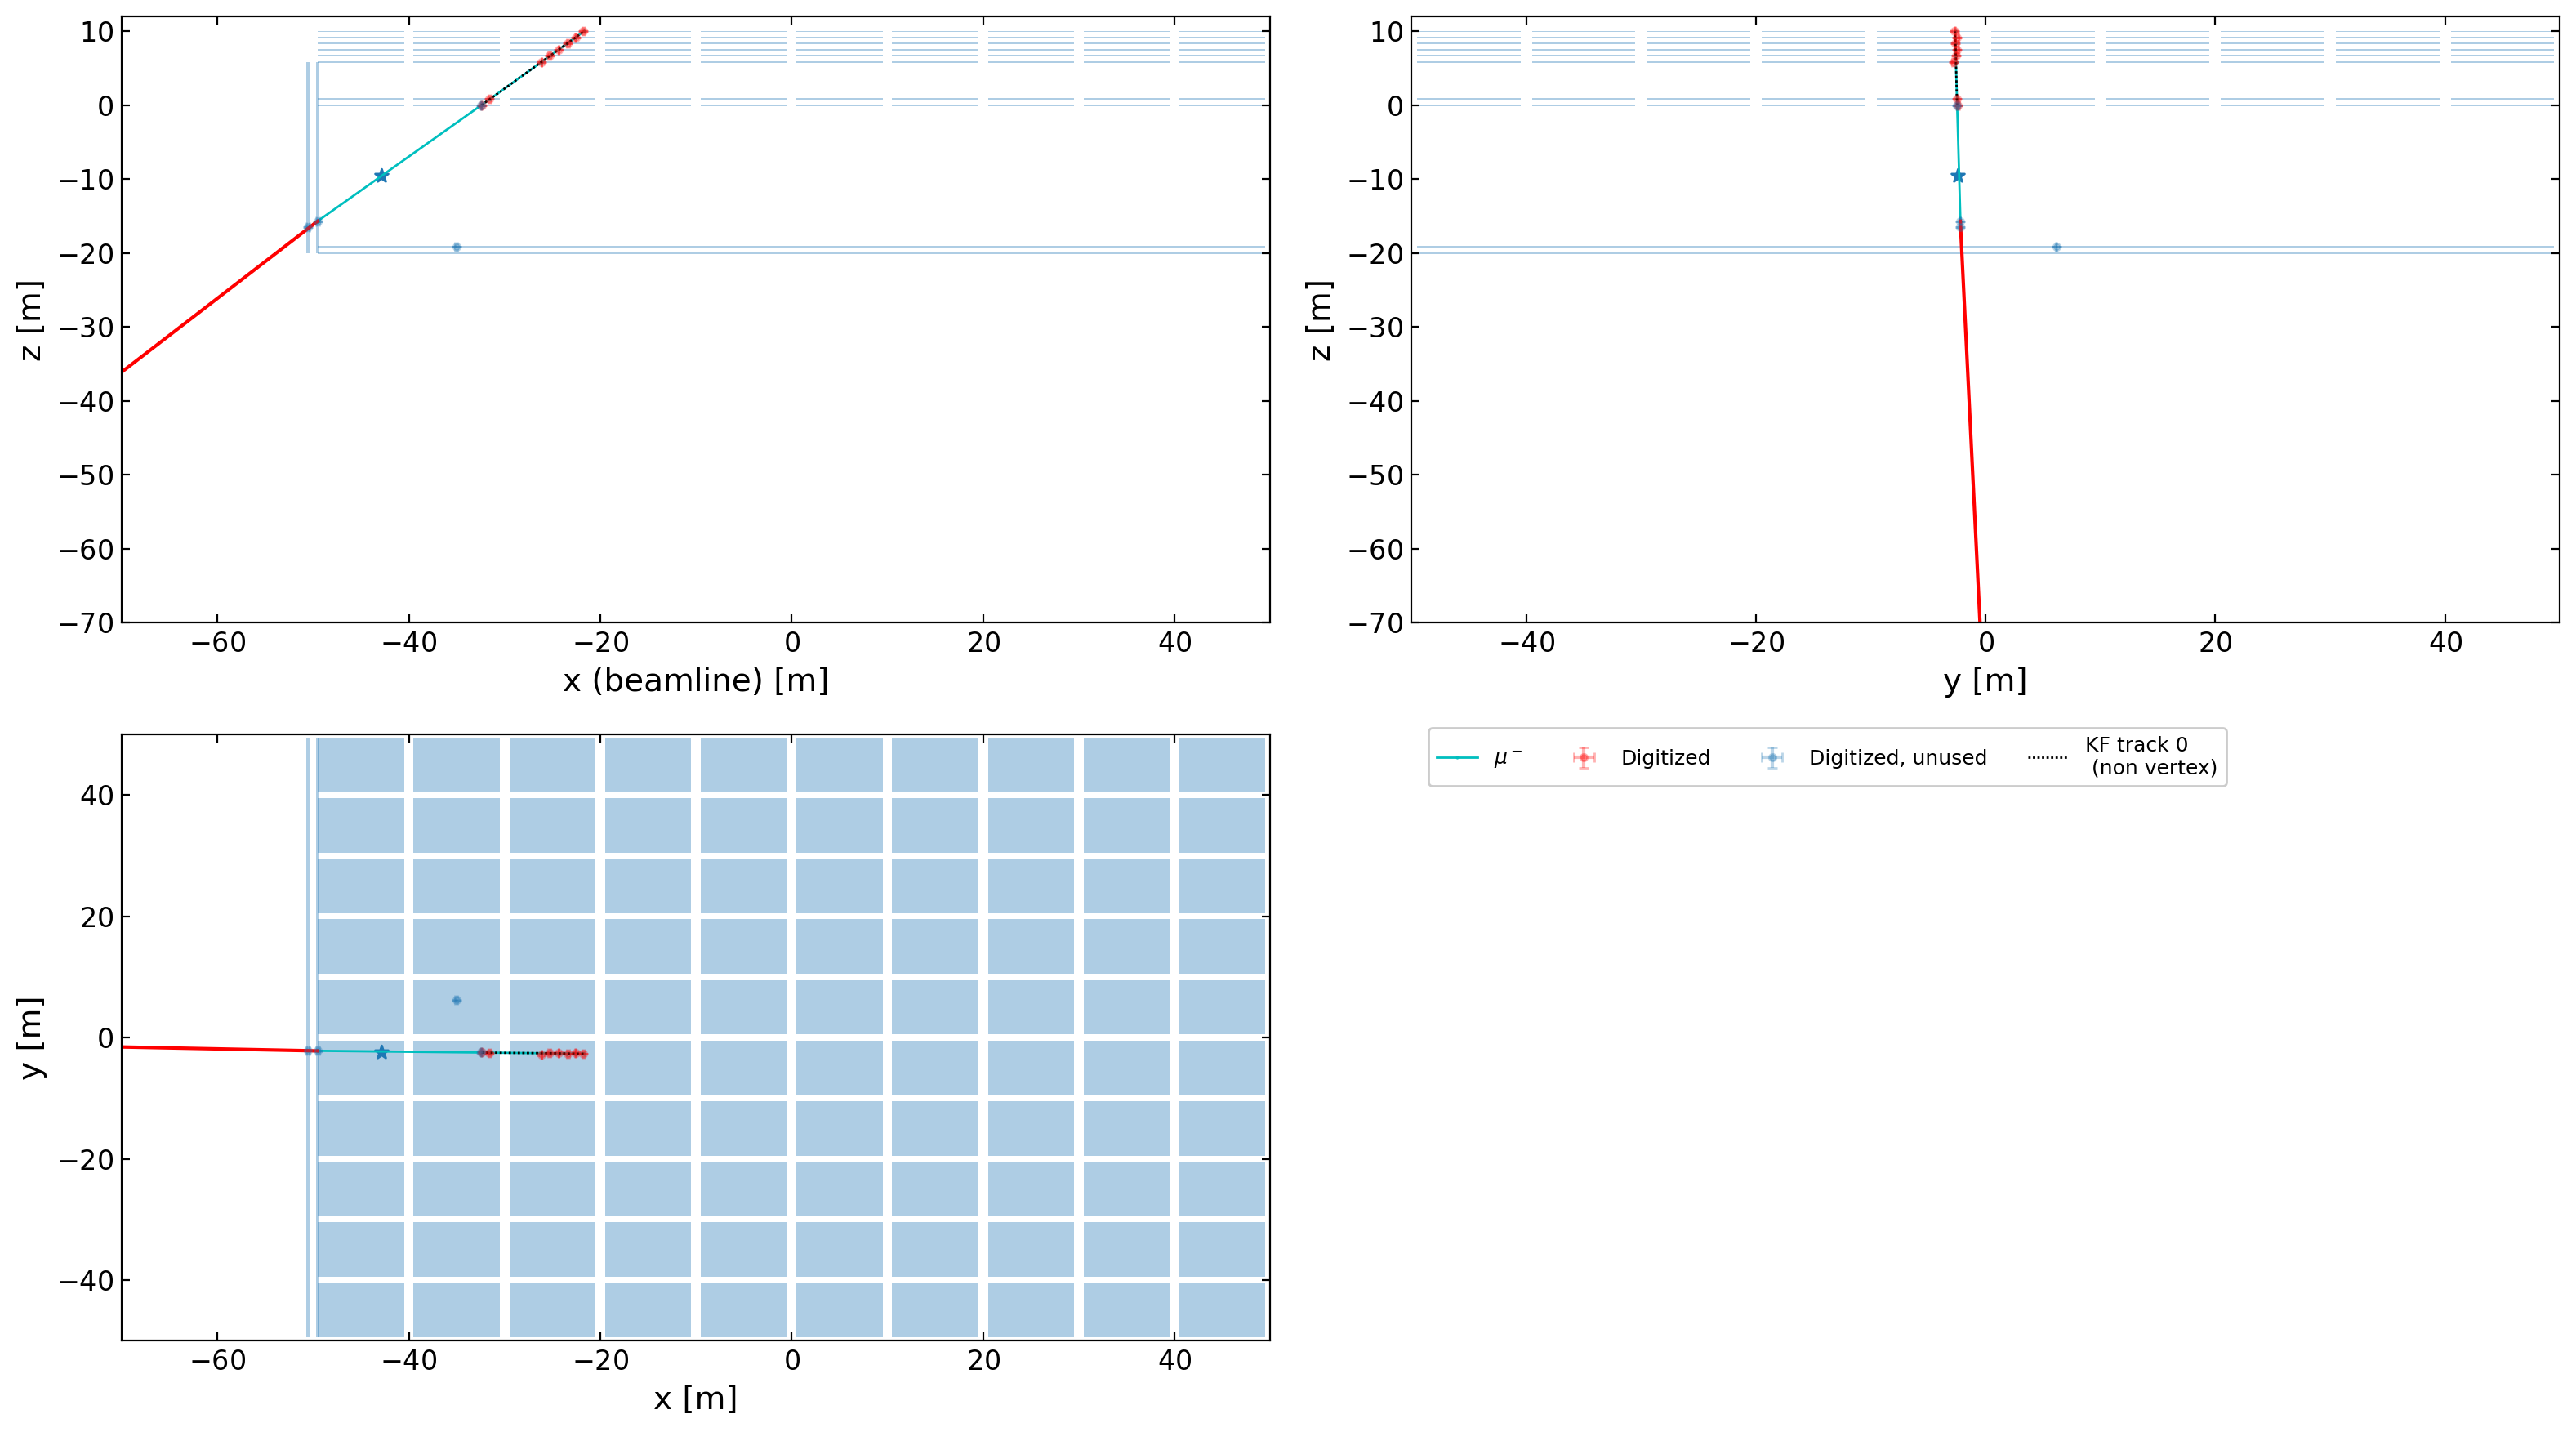

 60%|██████    | 18/30 [00:20<00:19,  1.60s/it]

Chi2: 81.0884755219532
 Distance: 86.0924212691396
[[ 1.80010251e+02  0.00000000e+00  0.00000000e+00  5.44124462e-01
   5.45777426e-02  5.61253415e-02  0.00000000e+00]
 [ 0.00000000e+00  1.68750000e+00  0.00000000e+00  5.11637201e-04
   2.72732305e-03 -2.54944149e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-01  1.03929899e-04
  -5.03593381e-04  5.10564584e-04  0.00000000e+00]
 [ 5.44124462e-01  5.11637201e-04  1.03929899e-04  1.64493514e-03
   1.65644298e-04  1.69038619e-04  0.00000000e+00]
 [ 5.45777426e-02  2.72732305e-03 -5.03593381e-04  1.65644298e-04
   2.17162526e-05  1.21250415e-05  0.00000000e+00]
 [ 5.61253415e-02 -2.54944149e-03  5.10564584e-04  1.69038619e-04
   1.21250415e-05  2.21329774e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 6.36733433e+01  0.00000000e+00 -8.04413258e-04 -1.37886698e+00
  -1.87943227e-02 -1.09582866e-02 -1.69256156e-02]
 [ 0.0000000

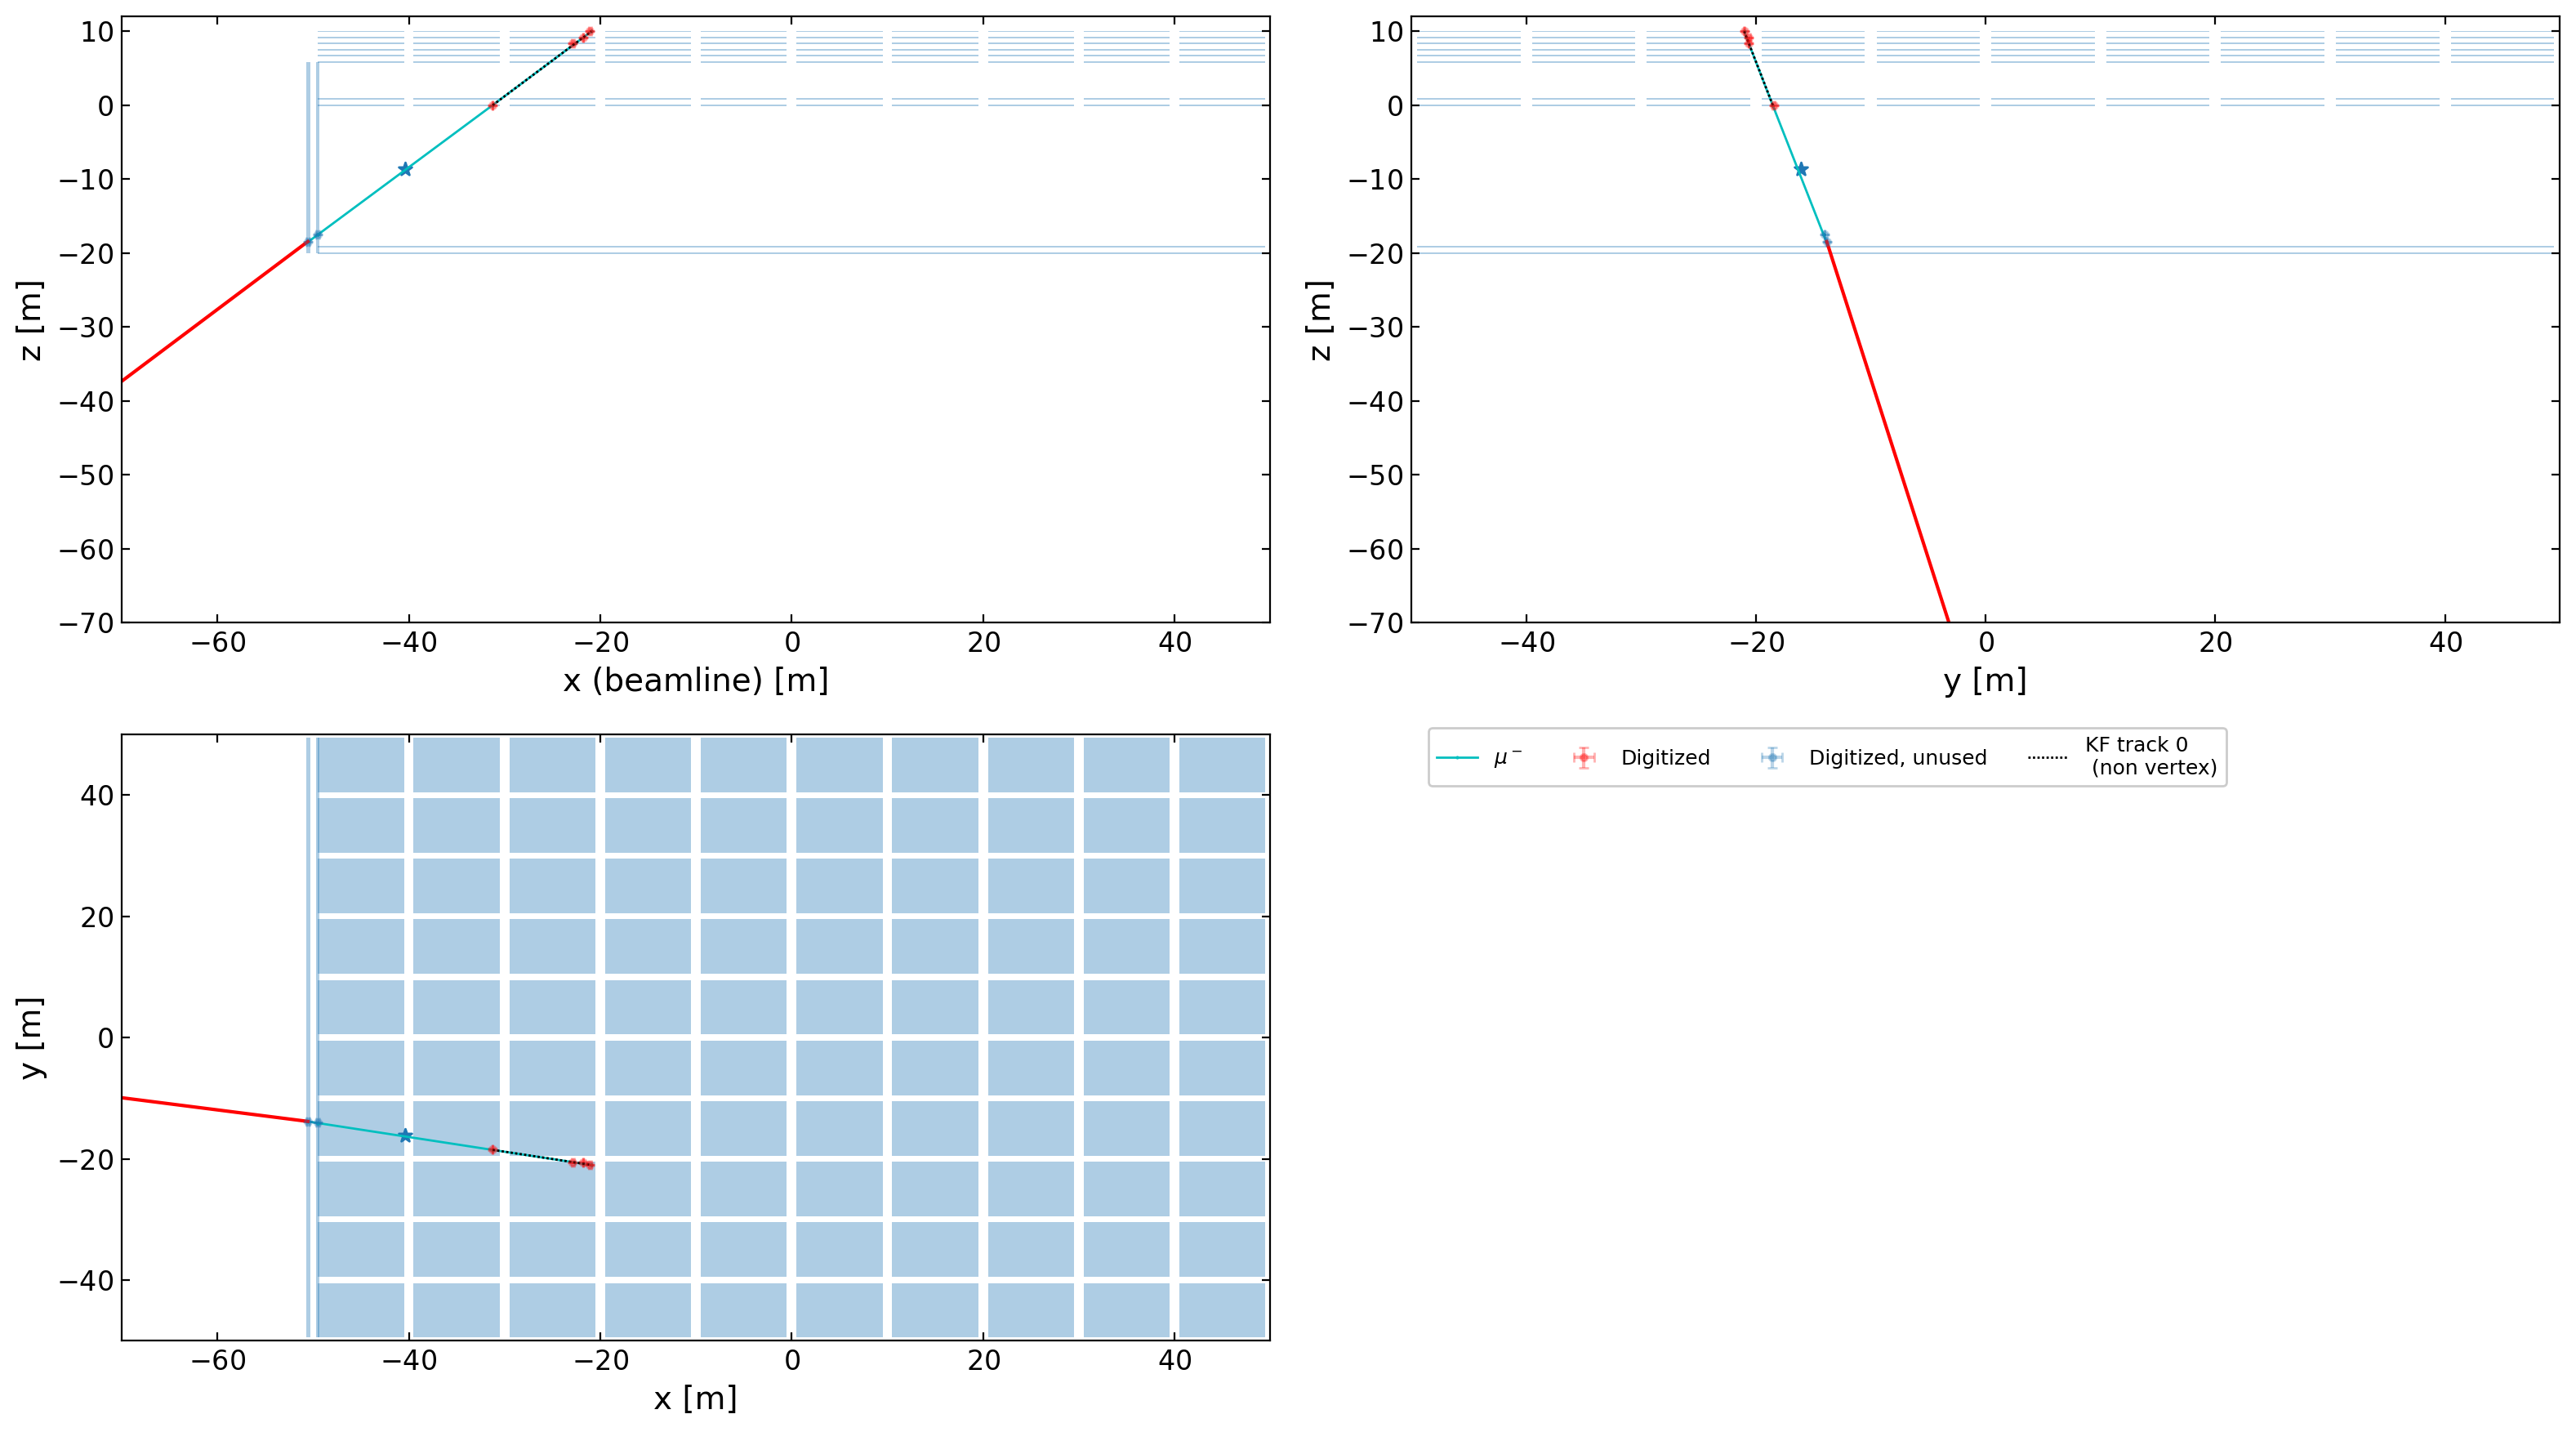

 83%|████████▎ | 25/30 [00:23<00:04,  1.20it/s]

Chi2: 189.19453327049354
 Distance: 58.580344528609665
[[ 1.80010251e+02  0.00000000e+00  0.00000000e+00  5.44401219e-01
   1.82027921e-02  1.77354312e-02  0.00000000e+00]
 [ 0.00000000e+00  1.68750000e+00  0.00000000e+00  1.70641458e-04
   2.49650024e-03 -2.55087245e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-01  3.28415208e-05
  -5.03876040e-04  5.19351035e-04  0.00000000e+00]
 [ 5.44401219e-01  1.70641458e-04  3.28415208e-05  1.64644166e-03
   5.52531257e-05  5.34301143e-05  0.00000000e+00]
 [ 1.82027921e-02  2.49650024e-03 -5.03876040e-04  5.52531257e-05
   6.29569656e-06 -2.76542347e-06  0.00000000e+00]
 [ 1.77354312e-02 -2.55087245e-03  5.19351035e-04  5.34301143e-05
  -2.76542347e-06  6.41252262e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.96941339e+00  0.00000000e+00 -4.61733215e-04 -4.65164801e-02
   1.12805261e-03  8.06735396e-04  1.26290680e-03]
 [ 0.000

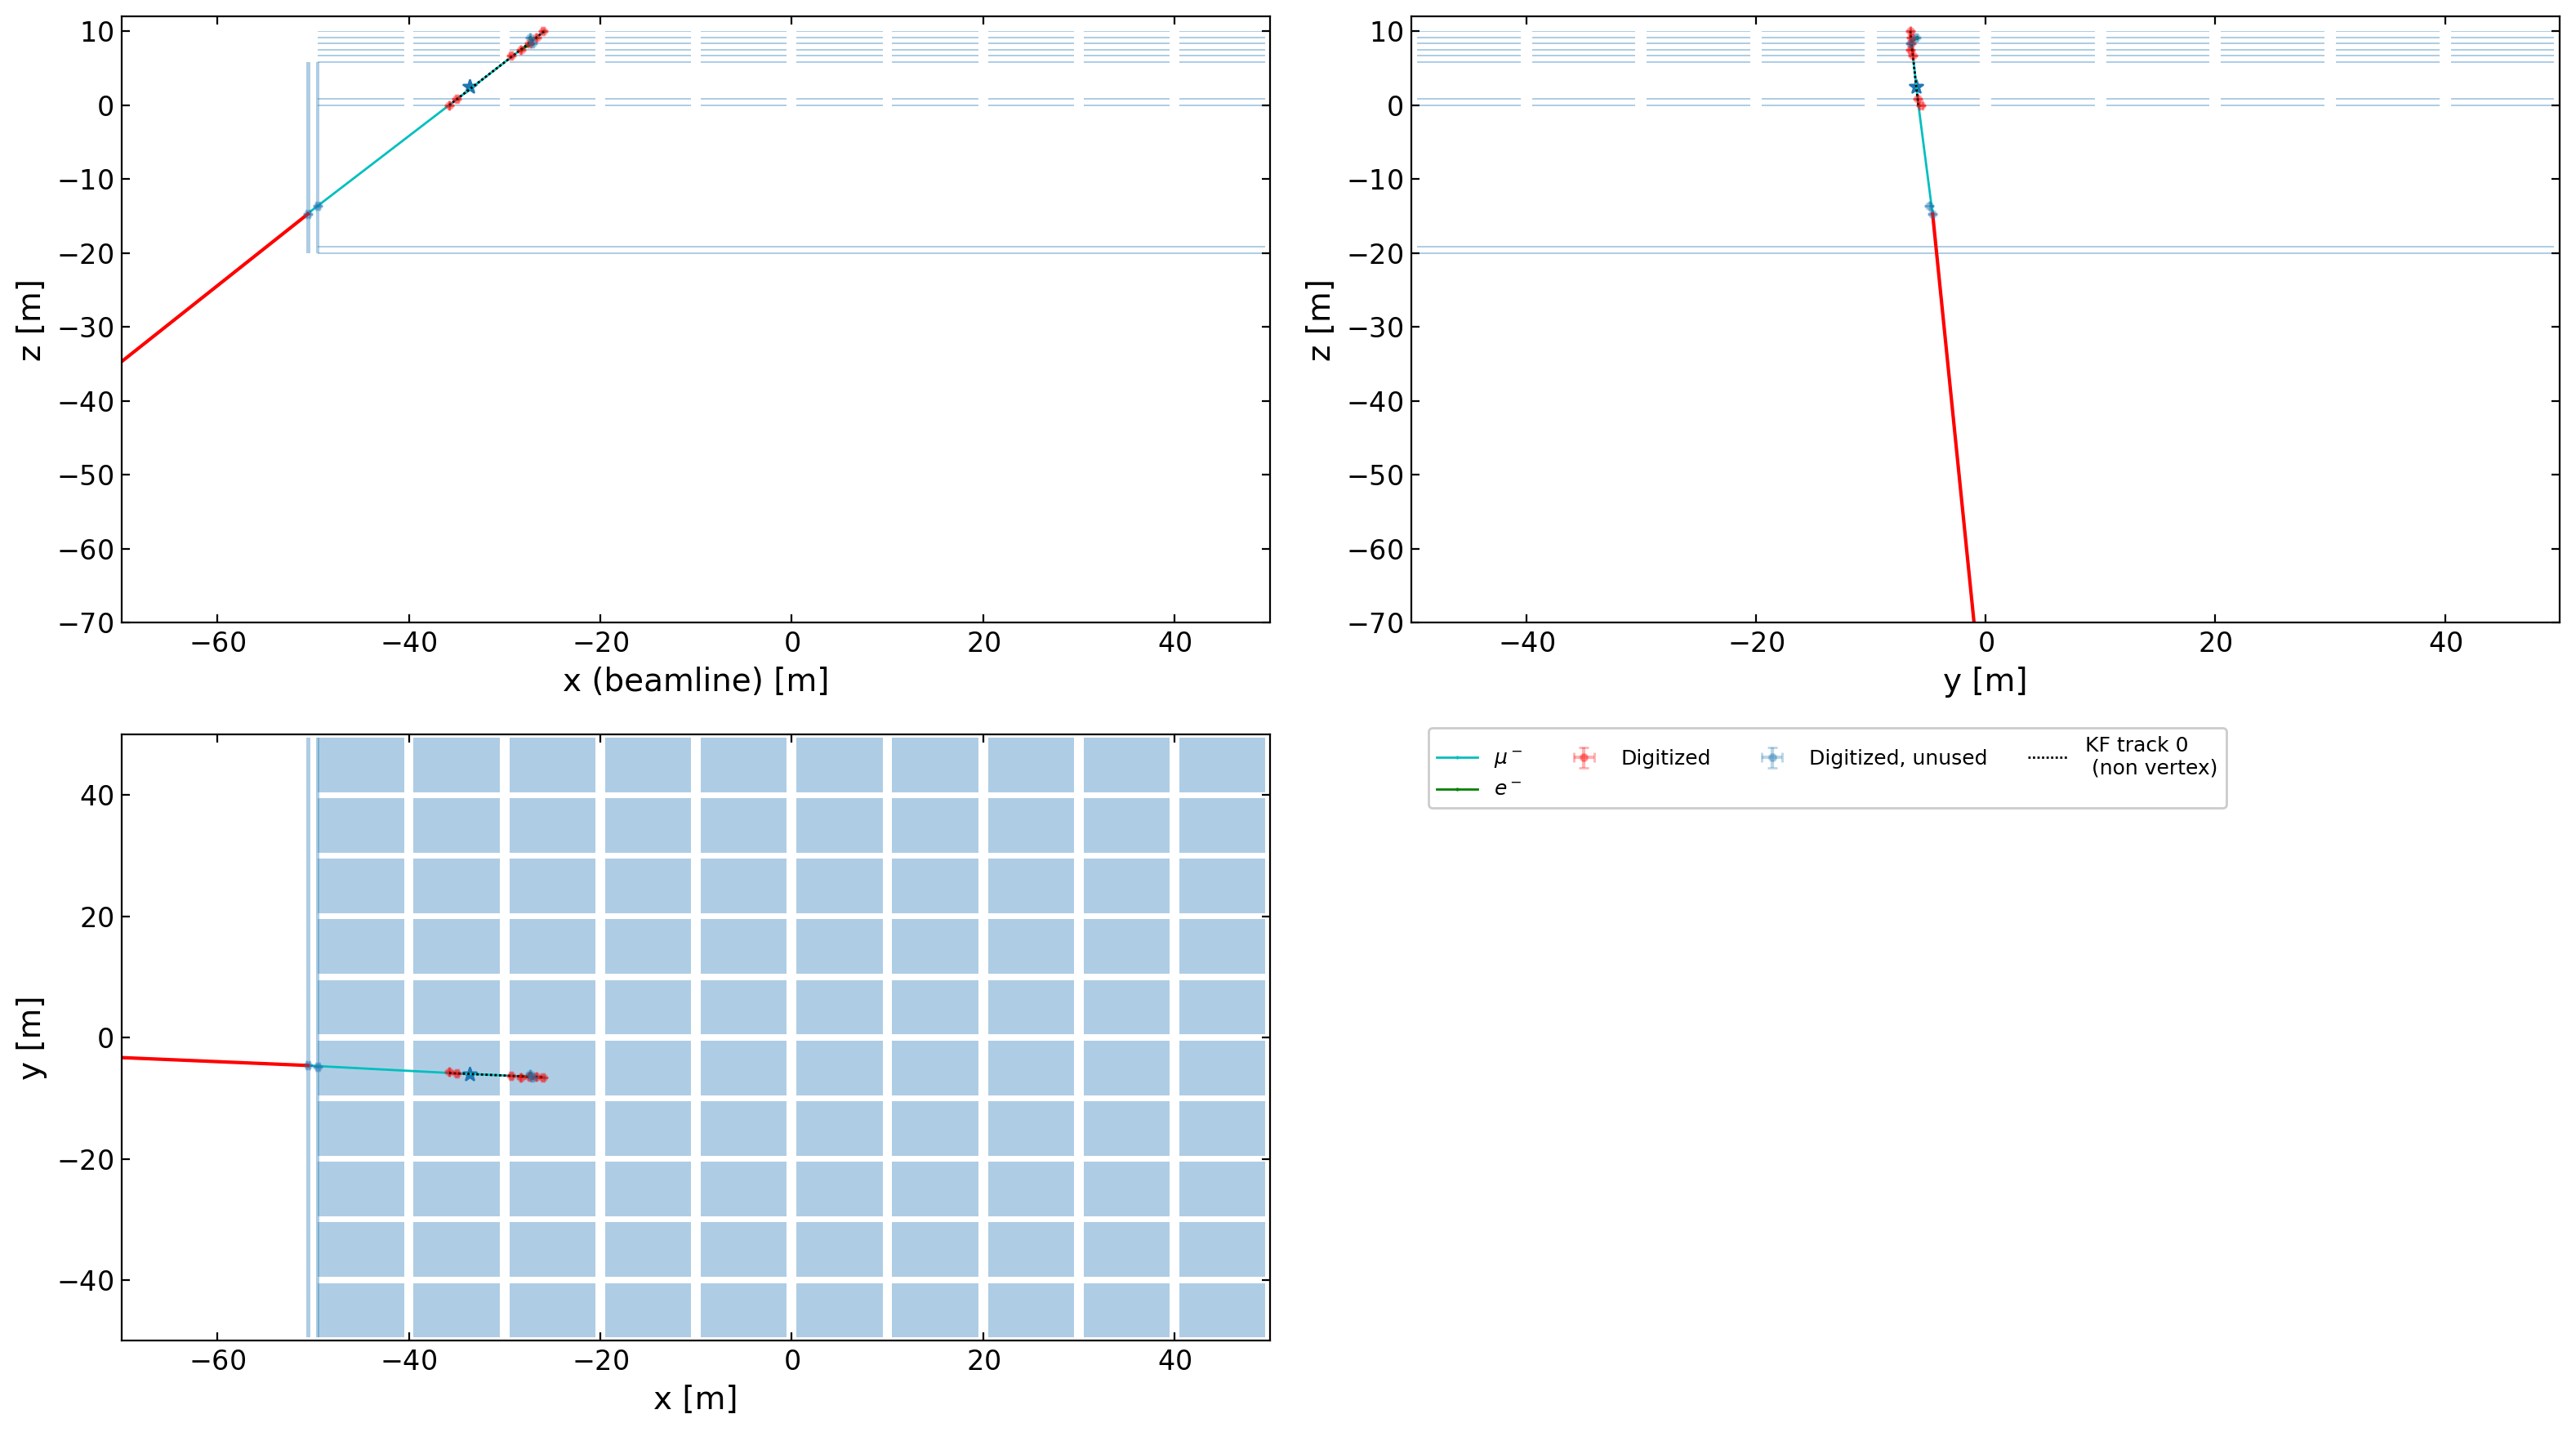

 90%|█████████ | 27/30 [00:25<00:02,  1.06it/s]

Chi2: 41.74257683283363
 Distance: 61.48502350800052
[[ 1.68750000e+00  0.00000000e+00  0.00000000e+00  3.74756127e-03
  -4.21516683e-04 -6.82695152e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-01  0.00000000e+00 -8.32625547e-05
   5.69877172e-04 -3.30909119e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.80010251e+02 -7.28249631e-02
  -1.78701100e-01  1.28659518e-01  0.00000000e+00]
 [ 3.74756127e-03 -8.32625547e-05 -7.28249631e-02  3.78053696e-05
   7.12168903e-05 -5.34839631e-05  0.00000000e+00]
 [-4.21516683e-04  5.69877172e-04 -1.78701100e-01  7.12168903e-05
   1.78481041e-04 -1.28119028e-04  0.00000000e+00]
 [-6.82695152e-04 -3.30909119e-04  1.28659518e-01 -5.34839631e-05
  -1.28119028e-04  9.25620775e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.98850419e+00  0.00000000e+00  1.10720631e-03 -3.26085070e-02
   9.20689321e-05  3.44529327e-04  1.25883991e-03]
 [ 0.00000

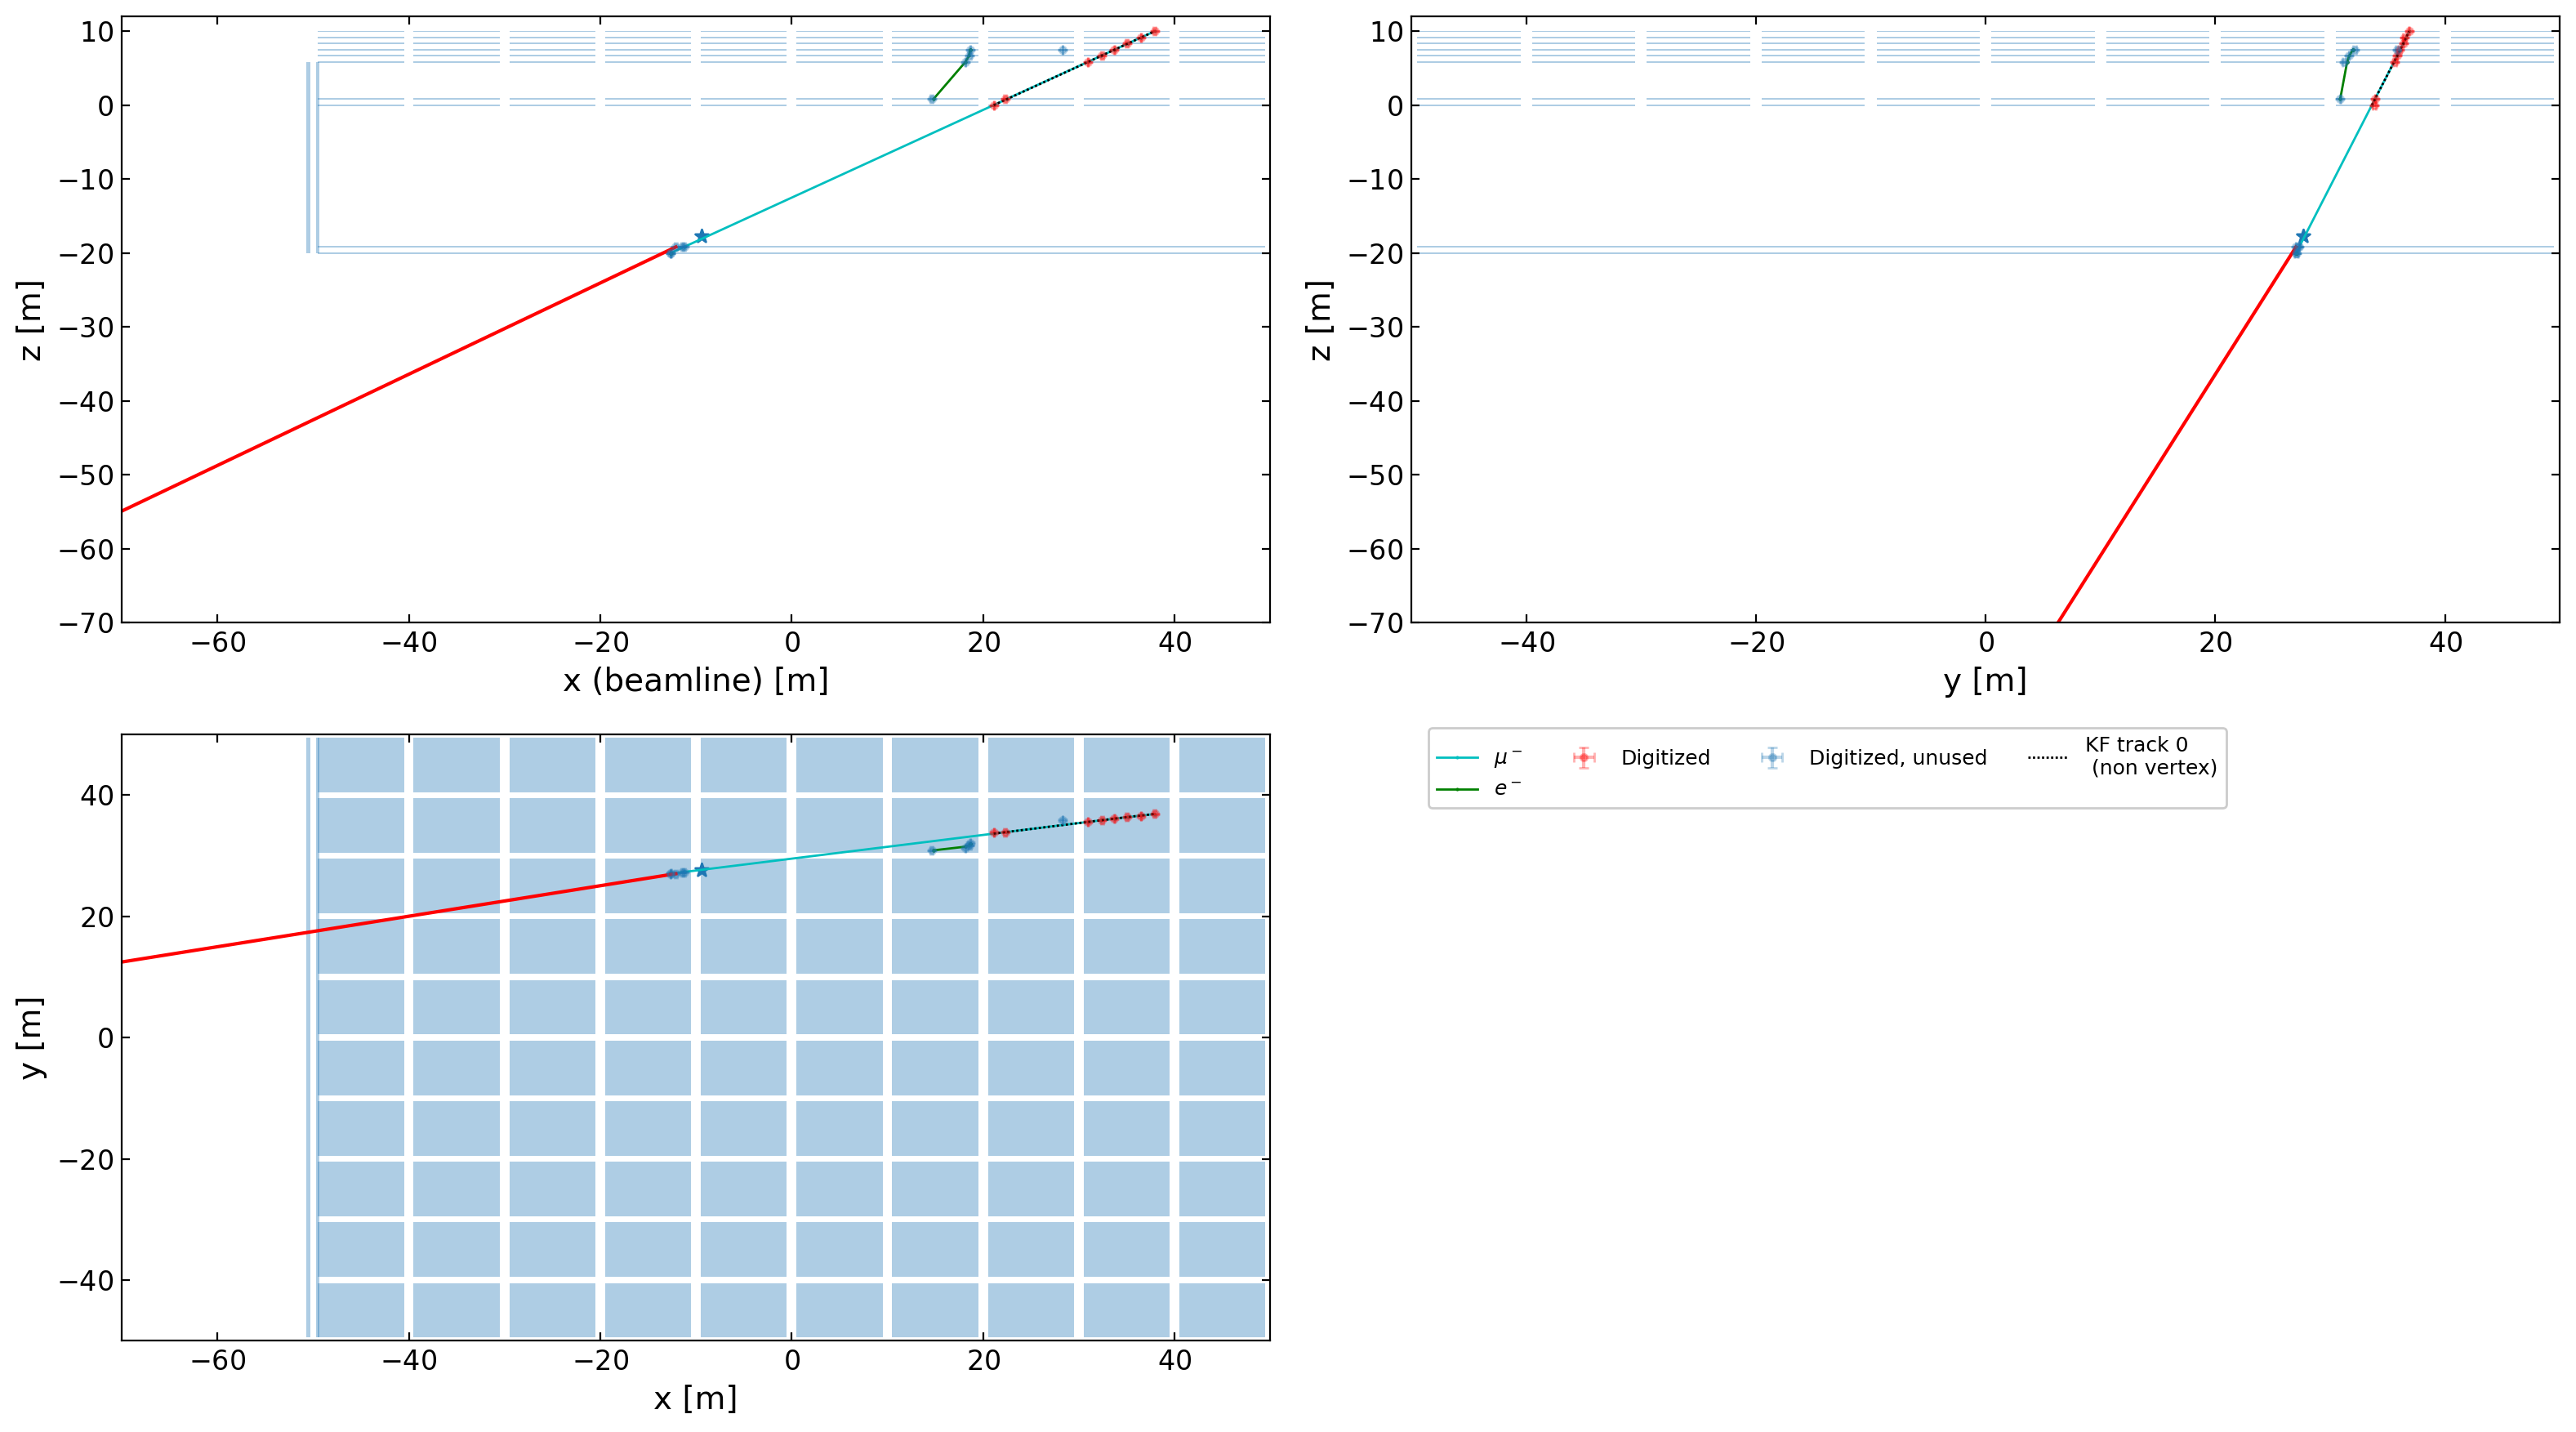

100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


In [71]:
ev = event.Event(filename, 0, tree_name=tree_name)

# for entry in tqdm(range(nevents)):
for entry in tqdm(range(0,30)):
    Tree.GetEntry(entry)
    ev.EventNumber=entry
    ev.Tree.GetEntry(ev.EventNumber)
    
    


    # Tracks
    track_digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
    n_tracks_recon = len(track_digi_hit_inds)
    tracks_chi2_to_fwhits=[]
    tracks_dist_to_fwhits=[]
    tracks_chi2_to_IPtrack=[]
    tracks_dist_to_IPtrack=[]
    tracks_deflection=[]
    momentum_truth = [Tree.GenParticle_py[0], -Tree.GenParticle_pz[0], Tree.GenParticle_px[0]]
    momentum_truth_unit = momentum_truth/np.linalg.norm(momentum_truth)

    if n_tracks_recon>0:

        # Hits
        hits_x = np.array(util.c2list(Tree.Digi_x))
        hits_y = np.array(util.c2list(Tree.Digi_y))
        hits_z = np.array(util.c2list(Tree.Digi_z))
        hits_t = np.array(util.c2list(Tree.Digi_time))
        hits_layer = np.array(util.c2list(Tree.Digi_layer_id))
        mask_non_fw = (hits_z>=MODULE_Z_RANGE_CMS_cm[0]) & (hits_y>=MODULE_Y_RANGE_CMS_cm[0])
        hits_xyz_non_fw = np.array([hits_x[mask_non_fw], hits_y[mask_non_fw], hits_z[mask_non_fw], hits_t[mask_non_fw]]).T
        hits_xyz_fw = np.array([hits_x[~mask_non_fw], hits_y[~mask_non_fw], hits_z[~mask_non_fw], hits_t[~mask_non_fw]]).T
        hits_id_fw = hits_layer[~mask_non_fw]
        n_hits_fw = len(hits_xyz_fw)
        
        # Loop track, and for each track loop F/W hits
        if n_hits_fw>0:
            for itrack in range(n_tracks_recon):
                track_param = get_track_param(Tree, itrack)
                track_cov = get_track_cov(Tree, itrack)
                momentum_measured = track_param[3:6]
                momentum_measured_unit = momentum_measured/np.linalg.norm(momentum_measured)

                chi2_to_fwhits = []
                dist_to_fwhits = []
                chi2_to_IPtrack= []
                dist_to_IPtrack= []                

                for ihit, hit in enumerate(hits_xyz_fw):
                    # Hit uncertainty:
                    hit_uncertainty = get_hit_uncertainty(1, hits_id_fw[ihit])
                    
                    # Method 1: Calculate chi2 between F/W hits and track
                    dt = hit[-1]-track_param[-1]
                    track_new_loc = track_point_propagation(track_param,dt)
                    dr = track_new_loc[:3] - hit[:3]
                    # Total covariance is the track cov + hit cov
                    track_new_pcov = track_cov_propagation(track_param, track_cov, dt, dt_err_add=1) + np.diag(hit_uncertainty**2)
                    chi2 = dr.T@np.linalg.inv(track_new_pcov)@dr
                    # chi2 = chi2_distance_to(track_param, track_cov, hit[:3], hit[3], point_t_err = 1)
                    chi2_to_fwhits.append(chi2)
                    dist_to_fwhits.append(np.linalg.norm(dr))
                    
                    # Calculate chi2 between track and IP tracklet
                    # IP tracklet parameter
                    # Minimize chi2
                    # Log the distance and chi2 
                    dr_IP = np.linalg.norm(hit[:3])
                    dt_IP = dr_IP/29.94
                    v0_IP = hit[:3]/dt_IP
                    track2_par = [hit[0], hit[1], hit[2], v0_IP[0], v0_IP[1], v0_IP[2], hit[3]]
                    track2_cov = IP_track_cov(hit, np.append(hit_uncertainty,1))

                    fit1 = fit_vertex([track_param, track2_par], [track_cov, track2_cov], seedinedx=[0,1])
                    chi2_to_IPtrack.append(fit1.fval)
                    vertex_par=np.array(list(fit1.values))
                    vertex_par_detcoor = util.coord_cms2det(vertex_par[:3])
                    hit_detcoor = util.coord_cms2det(hit[:3])
                    track1_location_at_vertex = np.array(track_point_propagation(track_param,vertex_par[-1]-track_param[-1]))
                    track2_location_at_vertex = np.array(track_point_propagation(track2_par, vertex_par[-1]-track2_par[-1]))
                    dr_fit = np.linalg.norm(track1_location_at_vertex[:3] - track2_location_at_vertex[:3])
                    
                    
                    
                    if (fit1.fval>20)&(fit1.fval<1000):
                    # if (1):
                        print("Chi2:", fit1.fval)
                        print(" Distance:", dr_fit)
                        
                        print(track2_cov)
                        print(track_cov)
                        print("---")                        
                    
                    
                        fig,axs=plt.subplots(2,2,figsize=(16,9))
                        fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
                        fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True, disp_vertex_track_extension=True);
                        axs = fig.axes
                        axs[0].scatter(vertex_par_detcoor[0],vertex_par_detcoor[2],marker="*")
                        axs[1].scatter(vertex_par_detcoor[1],vertex_par_detcoor[2],marker="*")
                        axs[2].scatter(vertex_par_detcoor[0],vertex_par_detcoor[1],marker="*")
                        
                        axs[0].plot([-70-49.5, hit_detcoor[0]], [-85.47, hit_detcoor[2]], color="r" )
                        axs[1].plot([0, hit_detcoor[1]], [-85.47, hit_detcoor[2]], color="r" )
                        axs[2].plot([-70-49.5, hit_detcoor[0]], [0, hit_detcoor[1]], color="r" )
                        
                        axs[0].set_xlim(-70,50)
                        axs[0].set_ylim(-70,12)
                        axs[1].set_ylim(-70,12)
                        axs[2].set_xlim(-70,50)                        
                        
                        show()